### Code for Optimizing FATES Allometric Functions

#### Author: Katie Murenbeeld
#### Date: 19 July 2021

### 1. Load Libraries


In [1]:
# Load appropriate libraries
import xarray as xr
import random
import numpy as np
import pandas as pd
import scipy as sp
import math as m
from scipy import optimize
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

### 2. Define allometric functions that FATES currently uses

In [2]:
def d2h_chave2014(d,p1,p2,p3):
    h = np.exp( p1 + p2*np.log(d) + p3*np.log(d)**2.0)
    return(h)

def d2h_poorter2006(d,p1,p2,p3):
    h = p1*(1.0 - np.exp(p2*d**p3))
    return(h)

def d2h_2pwr(d,p1,p2):
    h = p1*d**p2
    return(h)

def d2h_obrien(d,p1,p2):
    h = 10.0**(np.log10(d)*p1+p2)
    return(h)

def d2h_martcano(d,p1,p2,p3):
    h = (p1*d**p2)/(p3+d**p2)
    return(h)

def carea_2pwr(d, p1, p2):
    c = p1 * d ** p2
    return(c)

def d2blmax_salda(d,p1,p2,p3,rho):
    blmax = p1 * d**p2 * rho**p3
    return(blmax)

def d2blmax_2pwr(d,p1,p2):
    c2b = 2.0
    blmax    = (p1*d**p2) / c2b
    return(blmax)

def d2bagw_choj(dbh,p1,p2):
    ln_agb = p1+(p2*np.log(dbh))
    agb_choj = np.exp(ln_agb)
    return agb_choj

def d2bagw_sal(dbh,p1,p2,p3,p4):
    agb_sal = allom_frac * p1 * (h_sal_mod**p2) * (dbh**p3) * (rho**p4)
    return agb_sal

def d2bagw_pow(dbh,p1,p2):
    agb_pow = (p1*np.power(dbh,p2))/c2b
    return agb_pow

### 3) Load data

Here we are using data from:

1. Falster et al., 2011 A Biomass and Allometry Database (BAAD)
2. USDA Forest Inventory Analysis (FIA) for Idaho
3. USDA Height and diameter at breast height (dbh) data from the Boise Basin Experimental Forest (BBEF)

We subset the data for Idaho or the western US. We are looking at common conifer species of Idaho. These include:

* Ponderosa pine (*Pinus ponderosa*)
* Lodgepole pine (*Pinus contorta*)
* Western white pine (*Pinus monticola*)
* Douglas-fir (*Pseudotsuga menziesii*)
* Western hemlock (*Tsuga heterophylla*)
* Western red cedar (*Thuja plicata*)
* Western larch (*Larix occidentalis*)
* Grand fir (*Abies grandis*)
* Subalpine fir (*Abies lasiocarpa*)
* Engelmann spruce (*Picea engelmanni*)

For now, I am looking at the pines, which will comprise for PFT1, and Douglas-fir and W. hemlock which will comprise PFT4.

In [3]:
# Set the directories
baad_dir = '/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/baad_downloads/baad_data/'
baad_dir_out = '/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/baad_downloads/baad_data_out/'
bbef_dir = '/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/BBEF/DATA/'
bbef_dir_out = '/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/BBEF/DATA/'
fia_dir = '/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/Benchmarking_Sensitivity/FIA/FIA_ID/'
fia_dir_out = '/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/Benchmarking_Sensitivity/FIA/FIA_ID_OUT/'

In [4]:
# Read in the BAAD data
baad_df = pd.read_csv(baad_dir + 'baad_data_2.csv').reset_index() 
baad_df = baad_df[['species', 'location', 'h.t', 'd.bh', 'a.lf', 'a.cp', 'm.lf', 'ma.ilf', 'n.lf', 'm.so']].copy()

# Read in the BBEF data
bbef_df = pd.read_csv(bbef_dir + 'BBEF-all-trees-height_DBH_calcs.csv')

# Read in the FIA Idaho census data
fia_df = pd.read_csv(fia_dir + 'ID_TREE.csv')
fia_df = fia_df[['PLT_CN', 'COUNTYCD', 'INVYR', 'CONDID', 'AZIMUTH', 'SPCD', 'SPGRPCD', 
                       'DIA', 'HT', 'CR', 'CDENCD', 'BHAGE', 'FGROWCFGS', 'TPA_UNADJ',  
                       'DRYBIO_BG', 'CARBON_AG', 'CARBON_BG', 'DRYBIO_AG']].copy()

/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (102) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# For the FIA data rename the species of interest

conditions = [
        (fia_df['SPCD'] == 202), # Douglas fir
        (fia_df['SPCD'] == 242), # Western red cedar
        (fia_df['SPCD'] == 19),  # Subalpine fir
        (fia_df['SPCD'] == 119), # Western white pine
        (fia_df['SPCD'] == 17),  # Grand fir
        (fia_df['SPCD'] == 73),  # Western larch
        (fia_df['SPCD'] == 122), # Ponderosa pine
        (fia_df['SPCD'] == 263), # Western hemlock
        (fia_df['SPCD'] == 108), # Lodgepole pine
        (fia_df['SPCD'] == 93),  # Engleman spruce
    ]
choices = ['doug-fir', 'w_redcedar', 'subap_fir', 'ww_pine', 'grand_fir', 'w_larch', 'pondo_pine', 'w_hem', 'lodge_pine', 'engle_spruce']
    
fia_df['SPECIES'] = np.select(conditions, choices, default='none')

fia_df.head(2)



,PLT_CN,COUNTYCD,INVYR,CONDID,AZIMUTH,SPCD,SPGRPCD,DIA,HT,CR,CDENCD,BHAGE,FGROWCFGS,TPA_UNADJ,DRYBIO_BG,CARBON_AG,CARBON_BG,DRYBIO_AG,SPECIES
0,3156095010690,9,1991,1,89.0,202,10,10.6,57.0,65.0,NaN,28.0,0.643645,13.054000,110.124965,240.460065,55.062483,NaN,doug-fir
1,3156095010690,9,1991,1,133.0,202,10,6.8,45.0,45.0,NaN,32.0,0.260028,31.720993,37.630405,80.531243,18.815203,NaN,doug-fir


In [6]:
# For each dataset sort out for the 10 conifer species of interest for the SCGSR work. Scratch that. 
# Just the species for PFT1 ( 3 pine species) and PFT 4 (W. Hemlock and Douglas Fir).

baad_pft1 = baad_df.loc[(baad_df['species'] == 'Pinus ponderosa') | (baad_df['species'] == 'Pinus monticola') | (baad_df['species'] == 'Pinus contorta')].copy()
baad_pft2 = baad_df.loc[(baad_df['species'] == 'Tsuga heterophylla') | (baad_df['species'] == 'Pseudotsuga menziesii')].copy()

bbef_pft1 = bbef_df.loc[(bbef_df['Species'] == 'Ponderosa pine') | (bbef_df['Species'] == 'Lodgepole pine')].copy()
bbef_pft2 = bbef_df.loc[(bbef_df['Species'] == 'Douglas fir')].copy()

fia_pft1 = fia_df.loc[(fia_df['SPECIES'] == 'pondo_pine') | (fia_df['SPECIES'] == 'lodge_pine') | (fia_df['SPECIES'] == 'ww_pine')].copy()
fia_pft2 = fia_df.loc[(fia_df['SPECIES'] == 'doug-fir') | (fia_df['SPECIES'] == 'w_hem')].copy()


In [10]:
# Clean up and convert USDA FS data to metric 
baad_pft1['DBH (cm)'] = baad_pft1['d.bh']*100
baad_pft2['DBH (cm)'] = baad_pft2['d.bh']*100

bbef_pft1['DBH (m)'] = bbef_pft1['DBH (cm)']/100
bbef_pft1 = bbef_pft1.drop(columns = ['Unnamed: 10', 'Unnamed: 11', 'param 1', 'param 2'])
bbef_pft2['DBH (m)'] = bbef_pft2['DBH (cm)']/100
bbef_pft2 = bbef_pft2.drop(columns = ['Unnamed: 10', 'Unnamed: 11', 'param 1', 'param 2'])

fia_pft1['HT (m)'] = fia_pft1['HT'] * 0.3048
fia_pft1['DBH (cm)'] = fia_pft1['DIA'] * 2.54
fia_pft1['DBH (m)'] = fia_pft1['DIA'] * 0.0254
fia_pft2['HT (m)'] = fia_pft2['HT'] * 0.3048
fia_pft2['DBH (cm)'] = fia_pft2['DIA'] * 2.54
fia_pft2['DBH (m)'] = fia_pft2['DIA'] * 0.0254

In [12]:
baad_pft2.head(2)
#bbef_2pfts

,species,location,h.t,d.bh,a.lf,a.cp,m.lf,ma.ilf,n.lf,m.so,DBH (cm)
3445,Tsuga heterophylla,northern Rocky Mountains U.S.A.,1.09728,NaN,NaN,0.143013,0.038012,NaN,NaN,NaN,NaN
3454,Tsuga heterophylla,northern Rocky Mountains U.S.A.,1.15824,NaN,NaN,0.263407,0.044997,NaN,NaN,NaN,NaN


In [14]:
# Review the max and min height by location (BAAD only)
print("max = ", baad_pft1.groupby('location')['h.t'].max(), "\nmin = ", baad_pft1.groupby('location')['h.t'].min())
print("max = ", baad_pft2.groupby('location')['h.t'].max(), "\nmin = ", baad_pft2.groupby('location')['h.t'].min())


max =  location
Gavin Lake                                                                                    5.040000
Priest River Experimental Forest                                                             44.989998
Pringle Butte and Lookout Mountain                                                           13.700000
central Oregon, USA                                                                          20.150000
eastern side of the Oregon Cascade Range, USA on a private forestland (Crown Pacific Co.)    35.750000
northern Rocky Mountains U.S.A.                                                              44.013120
western Montana, USA                                                                         22.070000
Name: h.t, dtype: float64 
min =  location
Gavin Lake                                                                                   0.39000
Priest River Experimental Forest                                                             3.57000
Pringle Butte and 

In [15]:
# Review the mean height by location (BAAD only)
print("mean\n", baad_pft1.groupby('location')['h.t'].mean())
print("mean\n", baad_pft2.groupby('location')['h.t'].mean())


mean
 location
Gavin Lake                                                                                    1.804070
Priest River Experimental Forest                                                             27.480488
Pringle Butte and Lookout Mountain                                                            9.044694
central Oregon, USA                                                                           7.442581
eastern side of the Oregon Cascade Range, USA on a private forestland (Crown Pacific Co.)    18.044303
northern Rocky Mountains U.S.A.                                                               9.679871
western Montana, USA                                                                          8.865385
Name: h.t, dtype: float64
mean
 location
Coast Range  Oregon, USA                43.669167
Coast Range  Roseburg Oregon, USA        5.563333
Coastal Range Corvallis  Oregon, USA     1.727650
Elk Creek                               23.059167
Ostrander Road, Kelso, 

In [16]:
# Review basic stats on height
print("BAAD\n", baad_pft1['h.t'].describe(), "\nBBEF", bbef_pft1['H (m)'].describe(), "\nFIA", fia_pft1['HT'].describe())

# There is no way there is a 269 m tall tree at BBEF


BAAD
 count    483.000000
mean       8.374278
std        9.960790
min        0.390000
25%        1.680000
50%        3.810000
75%       11.430000
max       44.989998
Name: h.t, dtype: float64 
BBEF count    4037.000000
mean       17.002260
std        10.424332
min         0.304800
25%         8.991600
50%        16.459200
75%        23.774400
max       269.443200
Name: H (m), dtype: float64 
FIA count    59467.000000
mean        53.758269
std         22.709884
min          5.000000
25%         39.000000
50%         53.000000
75%         67.000000
max        200.000000
Name: HT, dtype: float64


In [17]:
print("BAAD\n", baad_pft2['h.t'].describe(), "\nBBEF", bbef_pft2['H (m)'].describe(), "\nFIA", fia_pft2['HT'].describe())


BAAD
 count    71.000000
mean     16.824821
std      14.502872
min       0.760000
25%       4.521960
50%      14.430000
75%      23.490000
max      48.190000
Name: h.t, dtype: float64 
BBEF count    1460.000000
mean       14.984427
std         7.863921
min         0.304800
25%         8.534400
50%        15.910560
75%        21.671280
max        39.014400
Name: H (m), dtype: float64 
FIA count    63650.000000
mean        57.998209
std         26.198245
min          1.000000
25%         39.000000
50%         56.000000
75%         75.000000
max        181.000000
Name: HT, dtype: float64


In [18]:
# Drop the index with the max height (269.4432m) from the bbef_2pfts

indx = bbef_pft1[ (bbef_pft1['H (m)'] == bbef_pft1['H (m)'].max())].index
bbef_pft1.drop(indx, inplace=True)

bbef_pft1['H (m)'].describe()

count    4036.000000
mean       16.939713
std         9.638272
min         0.304800
25%         8.991600
50%        16.459200
75%        23.774400
max        48.158400
Name: H (m), dtype: float64

In [14]:
indx

Int64Index([998], dtype='int64')

In [19]:
# Review basic stats on dbh
print("BAAD\n", baad_pft1['d.bh'].describe(), "\nBBEF", bbef_pft1['DBH (m)'].describe(), "\nFIA", fia_pft1['DBH (m)'].describe())
print("BAAD\n", baad_pft2['d.bh'].describe(), "\nBBEF", bbef_pft2['DBH (m)'].describe(), "\nFIA", fia_pft2['DBH (m)'].describe())



BAAD
 count    298.000000
mean       0.205520
std        0.189608
min        0.007620
25%        0.071120
50%        0.147320
75%        0.266925
max        0.863600
Name: d.bh, dtype: float64 
BBEF count    4036.000000
mean        0.289393
std         0.219865
min         0.002540
25%         0.132080
50%         0.233680
75%         0.404495
max         2.870200
Name: DBH (m), dtype: float64 
FIA count    59467.000000
mean         0.223316
std          0.129099
min          0.025400
25%          0.149860
50%          0.195580
75%          0.264160
max          1.747520
Name: DBH (m), dtype: float64
BAAD
 count    67.000000
mean      0.228026
std       0.209999
min       0.002540
25%       0.064308
50%       0.158000
75%       0.306500
max       0.695580
Name: d.bh, dtype: float64 
BBEF count    1460.000000
mean        0.219847
std         0.135763
min         0.002540
25%         0.127000
50%         0.203200
75%         0.304800
max         0.886460
Name: DBH (m), dtype: float64 
FI

In [21]:
# Combine all of the DBH and H datasets into one dataframe
TOT_DBHpft1 = pd.concat([baad_pft1['d.bh'], bbef_pft1['DBH (m)'], fia_pft1['DBH (m)']], axis=0, ignore_index=True)
TOT_Hpft1 = pd.concat([baad_pft1['h.t'], bbef_pft1['H (m)'], fia_pft1['HT (m)']], axis=0, ignore_index=True)

TOTpft1 = pd.concat([pd.DataFrame(TOT_DBHpft1, columns=['DBH(m)']), pd.DataFrame(TOT_Hpft1, columns=['H(m)'])], axis=1)
TOTpft1['DBH(cm)'] = TOTpft1['DBH(m)'] * 100
TOTpft1

,DBH(m),H(m),DBH(cm)
0,NaN,0.70104,NaN
1,NaN,0.85344,NaN
2,NaN,0.85344,NaN
3,NaN,0.85344,NaN
4,NaN,1.06680,NaN
...,...,...,...
67525,0.19558,7.92480,19.558
67526,0.13462,9.14400,13.462
67527,0.14224,6.09600,14.224
67528,0.15748,9.75360,15.748


In [22]:
# Combine all of the DBH and H datasets into one dataframe
TOT_DBHpft2 = pd.concat([baad_pft2['d.bh'], bbef_pft2['DBH (m)'], fia_pft2['DBH (m)']], axis=0, ignore_index=True)
TOT_Hpft2 = pd.concat([baad_pft2['h.t'], bbef_pft2['H (m)'], fia_pft2['HT (m)']], axis=0, ignore_index=True)

TOTpft2 = pd.concat([pd.DataFrame(TOT_DBHpft2, columns=['DBH(m)']), pd.DataFrame(TOT_Hpft2, columns=['H(m)'])], axis=1)
TOTpft2['DBH(cm)'] = TOTpft2['DBH(m)'] * 100
TOTpft2

,DBH(m),H(m),DBH(cm)
0,NaN,1.09728,NaN
1,NaN,1.15824,NaN
2,NaN,1.34112,NaN
3,NaN,1.37160,NaN
4,0.00508,1.79832,0.508
...,...,...,...
67844,1.08966,24.38400,108.966
67845,0.38862,20.42160,38.862
67846,0.40386,17.67840,40.386
67847,0.38354,14.32560,38.354


In [17]:
# Find the mean height for specified ranges of DBH. 
# Here for a dbh of 10cm I took the measurements from 5-15cm to represent 10cm dbh. 
# Repeat the process up to 90cm.
# These values will be used to calculate parameters from the allometric equations (this acutally may not be necessary)

# Set dbh_mod to the ranges of dbh needed for calculation. In this case I want an array from 10-90 in steps of 10.
dbh_mod = np.arange(10, 100, 10) 

baad_mean_h = []

for i in dbh_mod:
    mask =  (baad_2pfts['d.bh']>= ((i/100) - 0.05)) & (baad_2pfts['d.bh']<((i/100) + 0.05))
    tmp_ = baad_2pfts.loc[mask].copy()
    stats = tmp_['h.t'].mean()
    baad_mean_h.append(stats)
    
bbef_mean_h = []

for i in dbh_mod:
    mask =  (bbef_2pfts['DBH (m)']>= ((i/100) - 0.05)) & (bbef_2pfts['DBH (m)']<((i/100) + 0.05))
    tmp_ = bbef_2pfts.loc[mask].copy()
    stats = tmp_['H (m)'].mean()
    bbef_mean_h.append(stats)

fia_mean_h = []

for i in dbh_mod:
    mask =  (fia_2pfts['DBH (m)']>= ((i/100) - 0.05)) & (fia_2pfts['DBH (m)']<((i/100) + 0.05))
    tmp_ = fia_2pfts.loc[mask].copy()
    stats = tmp_['HT (m)'].mean()
    fia_mean_h.append(stats)
    
tot_mean_h = []

for i in dbh_mod:
    mask =  (TOT['DBH(m)']>= ((i/100) - 0.05)) & (TOT['DBH(m)']<((i/100) + 0.05))
    tot_ = TOT.loc[mask].copy()
    stats = tot_['H(m)'].mean()
    tot_mean_h.append(stats)

### 3) Fit parameters for the allometric functions using curve_fit()


In [25]:
## Create a vector or dataframe with the height and dbh values for each of the three datasets and for the combined 
## (TOT) dataset

BBEF_DBHpft1 = bbef_pft1['DBH (cm)'].values
BAAD_DBHpft1 = baad_pft1['DBH (cm)'].values
FIA_DBHpft1 = fia_pft1['DBH (cm)'].values
TOT_DBHpft1 = TOTpft1['DBH(cm)'].values

BBEF_Hpft1 = bbef_pft1['H (m)'].values
BAAD_Hpft1 = baad_pft1['h.t'].values
FIA_Hpft1 = fia_pft1['HT (m)'].values
TOT_Hpft1 = TOTpft1['H(m)'].values

#BAAD_Hobspft1 = baad_mean_h
#BBEF_Hobspft1 = bbef_mean_h
#FIA_Hobspft1 = fia_mean_h
#TOT_Hobspft1 = tot_mean_h


In [26]:
# If you would like you can define an objective/cost function for the d2h function. In this case RMSE.
# Then I want to create an objective function. I will use RMSE

def d2h_error(dbh,Hobs,p1,p2):
    h = 10**((np.log10(dbh))*p1+p2)
    RMSE = np.sqrt(np.mean((h-Hobs)**2)) # best to use numpy
    return RMSE

In [27]:
RMSE = d2h_error(10,6.24,0.65,0.18)
print(RMSE)

0.520829753919819


### 3.1) For the d2h allometries fit the data to all of the functions. Then just the datasets to the O'Brien function.

We will also randomly sample and optimize the parameters to get a distribution of p1 and p2 for the O'Brien equation.

[0.59266873 0.42895475]
[ 4.39046227e+01 -3.48500303e-02  8.55884927e-01]
[2.68502841 0.59267278]
[-0.14036417  1.27199261 -0.09957821]
[55.97481635  0.95677053 43.74938781]


/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


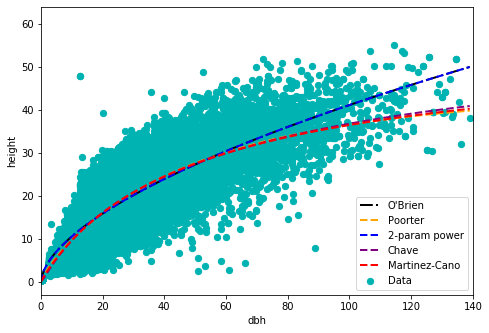

In [28]:
TOTpft1_na = TOTpft1.dropna(subset = ['DBH(cm)', 'H(m)']).copy()

pars_obrien, cov_obrien = curve_fit(f=d2h_obrien, xdata=TOTpft1_na['DBH(cm)'].dropna(), ydata=TOTpft1_na['H(m)'].dropna())
print(pars_obrien)
pars_poorter2006, cov_poorter2006 = curve_fit(f=d2h_poorter2006, xdata=TOTpft1_na['DBH(cm)'].dropna(), ydata=TOTpft1_na['H(m)'].dropna(), p0=[10,-0.01,1])
print(pars_poorter2006)
pars_2pwr, cov_2pwr = curve_fit(f=d2h_2pwr, xdata=TOTpft1_na['DBH(cm)'].dropna(), ydata=TOTpft1_na['H(m)'].dropna())
print(pars_2pwr)
pars_chave2014, cov_chave2014 = curve_fit(f=d2h_chave2014, xdata=TOTpft1_na['DBH(cm)'].dropna(), ydata=TOTpft1_na['H(m)'].dropna())
print(pars_chave2014)
pars_martcano, cov_martcano = curve_fit(f=d2h_martcano, xdata=TOTpft1_na['DBH(cm)'].dropna(), ydata=TOTpft1_na['H(m)'].dropna(), p0=[10,1,100])
print(pars_martcano)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh')
ax.set_ylabel('height')
ax.scatter(TOTpft1['DBH(cm)'], TOTpft1['H(m)'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), d2h_obrien(np.arange(140), *pars_obrien), linestyle='-.', linewidth=2, color='black', label="O'Brien")
ax.plot(np.arange(140), d2h_poorter2006(np.arange(140), *pars_poorter2006), linestyle='--', linewidth=2, color='orange', label="Poorter")
ax.plot(np.arange(140), d2h_2pwr(np.arange(140), *pars_2pwr), linestyle='--', linewidth=2, color='blue', label="2-param power")
ax.plot(np.arange(140), d2h_chave2014(np.arange(140), *pars_chave2014), linestyle='--', linewidth=2, color='purple', label="Chave")
ax.plot(np.arange(140), d2h_martcano(np.arange(140), *pars_martcano), linestyle='--', linewidth=2, color='red', label="Martinez-Cano")
ax.set_xlim(0,140)
ax.legend()

[0.83574714 0.02618859]
[0.6280095  0.34541606]
[0.59382925 0.42985093]


/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


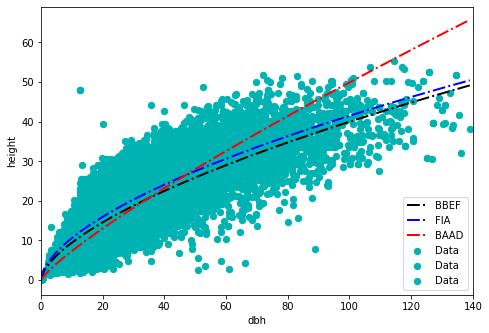

In [31]:
# Just using the O'Brien equation. Create optimal parameters for each of the three datasets.

baad_pft1na = baad_pft1.dropna(subset=['DBH (cm)'])
parsbaad_obrien, covbaad_obrien = curve_fit(f=d2h_obrien, xdata=baad_pft1na['DBH (cm)'], ydata=baad_pft1na['h.t'])
print(parsbaad_obrien)
parsbbef_obrien, covbbef_obrien = curve_fit(f=d2h_obrien, xdata=BBEF_DBHpft1, ydata=BBEF_Hpft1)
print(parsbbef_obrien)
parsfia_obrien, covfia_obrien = curve_fit(f=d2h_obrien, xdata=fia_pft1['DBH (cm)'].dropna(), ydata=fia_pft1['HT (m)'].dropna())
print(parsfia_obrien)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh')
ax.set_ylabel('height')
ax.scatter(fia_pft1['DBH (cm)'], fia_pft1['HT (m)'], s=40, color='#00b3b3', label='Data')
ax.scatter(BBEF_DBHpft1, BBEF_Hpft1, s=40, color='#00b3b3', label='Data')
ax.scatter(baad_pft1['DBH (cm)'], baad_pft1['h.t'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), d2h_obrien(np.arange(140), *parsbbef_obrien), linestyle='-.', linewidth=2, color='black', label="BBEF")
ax.plot(np.arange(140), d2h_obrien(np.arange(140), *parsfia_obrien), linestyle='-.', linewidth=2, color='blue', label="FIA")
ax.plot(np.arange(140), d2h_obrien(np.arange(140), *parsbaad_obrien), linestyle='-.', linewidth=2, color='red', label="BAAD")
ax.set_xlim(0,140)
ax.legend()



In [51]:
# From the total dataset, sample 1000 random samples and calculate the optimal parameters for O'Brien.
# Repeat the sampling and optimization 100 times.
# Create histograms for the two parameters.

smp_opt_d2h = []

def d2h_params(data):
    smp_mean_h = []
    for i in dbh_mod:
        smp = data.sample(1000).dropna()
            
    smp_opt, smp_cov = curve_fit(f=d2h_obrien, xdata=smp['DBH(cm)'], ydata=smp['H(m)'])
    smp_opt_d2h.append(smp_opt)
    return smp_opt

In [52]:
TOTpft1.sample(1000).dropna()

,DBH(m),H(m),DBH(cm)
15473,0.13970,13.7160,13.970
59337,0.19050,14.0208,19.050
31706,0.19558,12.8016,19.558
30871,0.24638,12.1920,24.638
42054,0.25400,13.1064,25.400
...,...,...,...
17855,0.14986,12.1920,14.986
25468,0.76708,32.3088,76.708
62981,0.20828,12.4968,20.828
60655,0.27432,22.5552,27.432


In [61]:
dbh_mod = np.arange(10, 100, 10)

smp_opt_d2h = []

for x in range(1,101):
    d2h_params(TOTpft1)
    D2H_PARAMS_DF = smp_opt_d2h

d2h_params_dfpft1 = pd.DataFrame(D2H_PARAMS_DF, columns=['d2h_p1', 'd2h_p2'])

(array([ 3.,  1.,  2.,  5., 19., 37., 20.,  7.,  5.,  1.]),
 array([0.53070308, 0.54238813, 0.55407319, 0.56575824, 0.57744329,
        0.58912835, 0.6008134 , 0.61249845, 0.62418351, 0.63586856,
        0.64755361]),
 <a list of 10 Patch objects>)

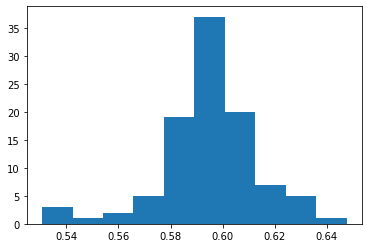

In [62]:
plt.hist(d2h_params_dfpft1['d2h_p1'])

(array([ 1.,  4., 10., 19., 38., 14.,  7.,  3.,  1.,  3.]),
 array([0.35483721, 0.37068512, 0.38653304, 0.40238095, 0.41822887,
        0.43407678, 0.4499247 , 0.46577262, 0.48162053, 0.49746845,
        0.51331636]),
 <a list of 10 Patch objects>)

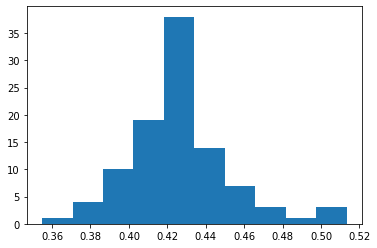

In [63]:
plt.hist(d2h_params_dfpft1['d2h_p2'])

In [64]:
# read out to a csv for use in the traits matrix
#d2h_params_dfpft1.to_csv('/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/SCGSR_PARAMS/d2h_params_PFT1_20210727.csv', index=False)


#### Now repeat for PFT 2

[0.55753893 0.44232206]
[ 3.10503293e+01 -2.49468688e-02  1.07983514e+00]
[2.68502841 0.59267278]
[-1.27759037  1.88718417 -0.18798501]
[37.38769325  1.26687972 68.70642146]


/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


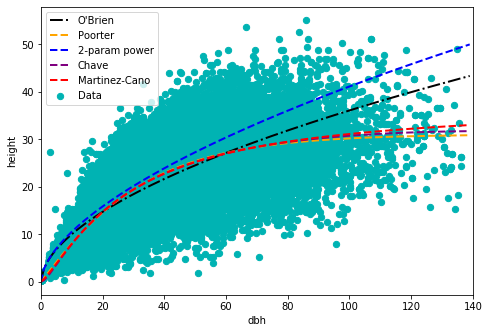

In [68]:
TOTpft2_na = TOTpft2.dropna(subset = ['DBH(cm)', 'H(m)']).copy()

pars_obrien, cov_obrien = curve_fit(f=d2h_obrien, xdata=TOTpft2_na['DBH(cm)'].dropna(), ydata=TOTpft2_na['H(m)'].dropna())
print(pars_obrien)
pars_poorter2006, cov_poorter2006 = curve_fit(f=d2h_poorter2006, xdata=TOTpft2_na['DBH(cm)'].dropna(), ydata=TOTpft2_na['H(m)'].dropna(), p0=[10,-0.01,1])
print(pars_poorter2006)
pars_2pwr, cov_2pwr = curve_fit(f=d2h_2pwr, xdata=TOTpft1_na['DBH(cm)'].dropna(), ydata=TOTpft1_na['H(m)'].dropna())
print(pars_2pwr)
pars_chave2014, cov_chave2014 = curve_fit(f=d2h_chave2014, xdata=TOTpft2_na['DBH(cm)'].dropna(), ydata=TOTpft2_na['H(m)'].dropna())
print(pars_chave2014)
pars_martcano, cov_martcano = curve_fit(f=d2h_martcano, xdata=TOTpft2_na['DBH(cm)'].dropna(), ydata=TOTpft2_na['H(m)'].dropna(), p0=[10,1,100])
print(pars_martcano)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh')
ax.set_ylabel('height')
ax.scatter(TOTpft2['DBH(cm)'], TOTpft2['H(m)'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), d2h_obrien(np.arange(140), *pars_obrien), linestyle='-.', linewidth=2, color='black', label="O'Brien")
ax.plot(np.arange(140), d2h_poorter2006(np.arange(140), *pars_poorter2006), linestyle='--', linewidth=2, color='orange', label="Poorter")
ax.plot(np.arange(140), d2h_2pwr(np.arange(140), *pars_2pwr), linestyle='--', linewidth=2, color='blue', label="2-param power")
ax.plot(np.arange(140), d2h_chave2014(np.arange(140), *pars_chave2014), linestyle='--', linewidth=2, color='purple', label="Chave")
ax.plot(np.arange(140), d2h_martcano(np.arange(140), *pars_martcano), linestyle='--', linewidth=2, color='red', label="Martinez-Cano")
ax.set_xlim(0,140)
ax.legend()

In [65]:
dbh_mod = np.arange(10, 100, 10)

smp_opt_d2h = []

for x in range(1,101):
    d2h_params(TOTpft2)
    D2H_PARAMS_DF = smp_opt_d2h

d2h_params_dfpft2 = pd.DataFrame(D2H_PARAMS_DF, columns=['d2h_p1', 'd2h_p2'])

(array([ 1.,  0.,  5.,  9., 13., 25., 16., 19.,  9.,  3.]),
 array([0.50387058, 0.51282506, 0.52177955, 0.53073404, 0.53968853,
        0.54864301, 0.5575975 , 0.56655199, 0.57550648, 0.58446097,
        0.59341545]),
 <a list of 10 Patch objects>)

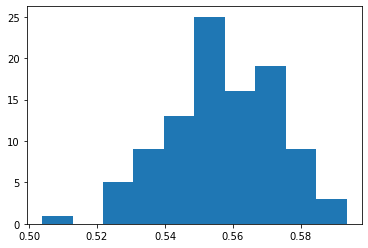

In [66]:
plt.hist(d2h_params_dfpft2['d2h_p1'])

(array([ 3.,  7., 13., 20., 23., 14., 13.,  6.,  0.,  1.]),
 array([0.38635004, 0.39953873, 0.41272743, 0.42591612, 0.43910482,
        0.45229351, 0.46548221, 0.4786709 , 0.49185959, 0.50504829,
        0.51823698]),
 <a list of 10 Patch objects>)

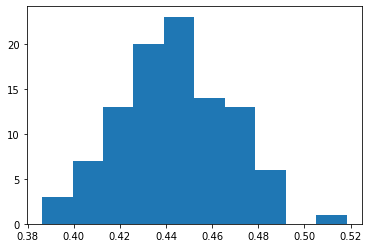

In [67]:
plt.hist(d2h_params_dfpft2['d2h_p2'])

In [69]:
# read out to a csv for use in the traits matrix
#d2h_params_dfpft2.to_csv('/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/SCGSR_PARAMS/d2h_params_PFT2_20210727.csv', index=False)

### 3.2) We will optimize for the leaf biomass and crown area allometries using the BAAD data. 

#### First, projected crown area ($m^2$)

In [70]:
baad_pft1.dropna(subset=['a.cp', 'DBH (cm)'])

,species,location,h.t,d.bh,a.lf,a.cp,m.lf,ma.ilf,n.lf,m.so,DBH (cm)
3477,Pinus ponderosa,northern Rocky Mountains U.S.A.,1.402080,0.00762,NaN,0.263407,0.066997,NaN,NaN,NaN,0.762
3485,Pinus monticola,northern Rocky Mountains U.S.A.,1.584960,0.01016,NaN,0.531921,0.366010,NaN,NaN,NaN,1.016
3488,Pinus ponderosa,northern Rocky Mountains U.S.A.,1.615440,0.01016,NaN,0.656693,0.074980,NaN,NaN,NaN,1.016
3489,Pinus monticola,northern Rocky Mountains U.S.A.,1.615440,0.00762,NaN,0.656693,0.309990,NaN,NaN,NaN,0.762
3492,Pinus monticola,northern Rocky Mountains U.S.A.,1.645920,0.01270,NaN,0.893832,0.397989,NaN,NaN,NaN,1.270
...,...,...,...,...,...,...,...,...,...,...,...
11641,Pinus ponderosa,Priest River Experimental Forest,3.570000,0.04830,6.221753,0.833229,0.808352,NaN,NaN,NaN,4.830
11642,Pinus ponderosa,Priest River Experimental Forest,31.929997,0.70610,970.338487,36.513951,135.146738,NaN,NaN,NaN,70.610
11643,Pinus ponderosa,Priest River Experimental Forest,6.920000,0.11430,36.523412,4.856518,4.806629,NaN,NaN,NaN,11.430
11644,Pinus ponderosa,Priest River Experimental Forest,5.849999,0.11940,34.204490,3.397947,4.770014,NaN,NaN,NaN,11.940


[0.05482925 1.58372154]


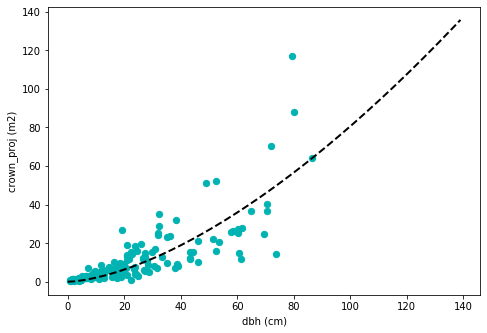

In [71]:
baad_acppft1 = baad_pft1.dropna(subset=['a.cp', 'DBH (cm)'])
crownarea_pars, crownarea_cov = curve_fit(f=carea_2pwr, xdata=baad_acppft1['DBH (cm)'], ydata=baad_acppft1['a.cp'])
print(crownarea_pars)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('crown_proj (m2)')
ax.scatter(baad_acppft1['DBH (cm)'], baad_acppft1['a.cp'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), carea_2pwr(np.arange(140), *crownarea_pars), linestyle='--', linewidth=2, color='black')


(array([132.,  31.,  19.,  12.,   8.,   8.,  10.,   2.,   4.,   2.,   6.,
          4.,   1.,   1.,   0.,   3.,   0.,   1.,   0.,   0.,   0.,   1.,
          1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([6.36172512e-03, 2.35283169e+00, 4.69930165e+00, 7.04577161e+00,
        9.39224158e+00, 1.17387115e+01, 1.40851815e+01, 1.64316515e+01,
        1.87781214e+01, 2.11245914e+01, 2.34710614e+01, 2.58175313e+01,
        2.81640013e+01, 3.05104712e+01, 3.28569412e+01, 3.52034112e+01,
        3.75498811e+01, 3.98963511e+01, 4.22428211e+01, 4.45892910e+01,
        4.69357610e+01, 4.92822309e+01, 5.16287009e+01, 5.39751709e+01,
        5.63216408e+01, 5.86681108e+01, 6.10145808e+01, 6.33610507e+01,
        6.57075207e+01, 6.80539906e+01, 7.04004606e+01, 7.27469306e+01,
        7.50934005e+01, 7.74398705e+01, 7.97863405e+01, 8.21328104e+01,
        8.

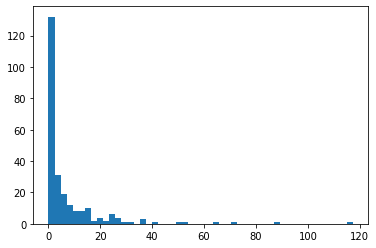

In [72]:
plt.hist(baad_pft1['a.cp'].dropna(), bins=50)

In [73]:
baad_pft1['a.cp'].describe()

count    250.000000
mean       7.233906
std       13.666750
min        0.006362
25%        0.306796
50%        2.127685
75%        7.889998
max      117.329860
Name: a.cp, dtype: float64

In [74]:
acppft1_log = np.log(baad_pft1['a.cp'])
acppft1_log.describe()

count    250.000000
mean       0.457774
std        2.063711
min       -5.057456
25%       -1.181572
50%        0.755035
75%        2.065571
max        4.764989
Name: a.cp, dtype: float64

#### Then, leaf area ($m^2$)

In [75]:
baad_pft1.dropna(subset=['a.lf', 'DBH (cm)'])

,species,location,h.t,d.bh,a.lf,a.cp,m.lf,ma.ilf,n.lf,m.so,DBH (cm)
5992,Pinus ponderosa,"eastern side of the Oregon Cascade Range, USA ...",32.60,0.627241,548.5200,NaN,75.39,0.139586,NaN,NaN,62.724080
5993,Pinus ponderosa,"eastern side of the Oregon Cascade Range, USA ...",33.60,0.544669,627.6800,NaN,85.41,0.137430,NaN,NaN,54.466945
5994,Pinus ponderosa,"eastern side of the Oregon Cascade Range, USA ...",34.10,0.661811,593.0900,NaN,94.95,0.159400,NaN,NaN,66.181146
5995,Pinus ponderosa,"eastern side of the Oregon Cascade Range, USA ...",31.70,0.677967,415.7100,NaN,62.74,0.154386,NaN,NaN,67.796716
5996,Pinus ponderosa,"eastern side of the Oregon Cascade Range, USA ...",33.50,0.608698,575.4500,NaN,83.92,0.143859,NaN,NaN,60.869755
...,...,...,...,...,...,...,...,...,...,...,...
12272,Pinus ponderosa,"central Oregon, USA",12.90,0.231140,122.5351,NaN,NaN,NaN,NaN,NaN,23.114000
12273,Pinus ponderosa,"central Oregon, USA",17.95,0.312420,132.5742,NaN,NaN,NaN,NaN,NaN,31.242000
12274,Pinus ponderosa,"central Oregon, USA",14.53,0.347980,134.6993,NaN,NaN,NaN,NaN,NaN,34.798000
12275,Pinus ponderosa,"central Oregon, USA",20.10,0.342900,287.5394,NaN,NaN,NaN,NaN,NaN,34.290000


[0.38561095 1.76415109]


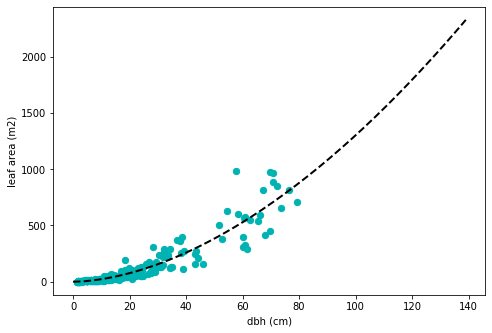

In [76]:
baad_alfpft1 = baad_pft1.dropna(subset=['a.lf', 'DBH (cm)'])
leafarea_pars, leafarea_cov = curve_fit(f=carea_2pwr, xdata=baad_alfpft1['DBH (cm)'], ydata=baad_alfpft1['a.lf'])
print(leafarea_pars)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf area (m2)')
ax.scatter(baad_alfpft1['DBH (cm)'], baad_alfpft1['a.lf'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), carea_2pwr(np.arange(140), *leafarea_pars), linestyle='--', linewidth=2, color='black')
#ax.set_xlim(0,100)

(array([186.,  36.,  13.,   8.,   8.,   4.,   4.,   1.,   4.,   4.,   1.,
          0.,   3.,   1.,   3.]),
 array([2.65147650e-02, 6.56656984e+01, 1.31304882e+02, 1.96944066e+02,
        2.62583249e+02, 3.28222433e+02, 3.93861616e+02, 4.59500800e+02,
        5.25139984e+02, 5.90779167e+02, 6.56418351e+02, 7.22057535e+02,
        7.87696718e+02, 8.53335902e+02, 9.18975085e+02, 9.84614269e+02]),
 <a list of 15 Patch objects>)

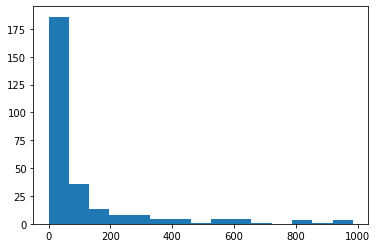

In [77]:
plt.hist(baad_pft1['a.lf'].dropna(), bins=15)

In [78]:
baad_pft1['a.lf'].describe()

count    276.000000
mean     102.060848
std      185.220296
min        0.026515
25%        4.611150
50%       27.615000
75%       98.462500
max      984.614269
Name: a.lf, dtype: float64

In [79]:
alfpft1_log = np.log(baad_pft1['a.lf'])
alfpft1_log.describe()

count    276.000000
mean       2.964593
std        2.276905
min       -3.630054
25%        1.528418
50%        3.318294
75%        4.589101
max        6.892250
Name: a.lf, dtype: float64

#### Calculate the leaf crown exponent difference

In [80]:
leaf_crown_exponent_diff = crownarea_pars[1] - leafarea_pars[1]
print(leaf_crown_exponent_diff)

-0.18042955811174477


#### Next, the leaf mass (kg)

In [81]:
baad_pft1.dropna(subset=['m.lf', 'DBH (cm)'])

,species,location,h.t,d.bh,a.lf,a.cp,m.lf,ma.ilf,n.lf,m.so,DBH (cm)
3477,Pinus ponderosa,northern Rocky Mountains U.S.A.,1.402080,0.00762,NaN,0.263407,0.066997,NaN,NaN,NaN,0.762
3485,Pinus monticola,northern Rocky Mountains U.S.A.,1.584960,0.01016,NaN,0.531921,0.366010,NaN,NaN,NaN,1.016
3488,Pinus ponderosa,northern Rocky Mountains U.S.A.,1.615440,0.01016,NaN,0.656693,0.074980,NaN,NaN,NaN,1.016
3489,Pinus monticola,northern Rocky Mountains U.S.A.,1.615440,0.00762,NaN,0.656693,0.309990,NaN,NaN,NaN,0.762
3492,Pinus monticola,northern Rocky Mountains U.S.A.,1.645920,0.01270,NaN,0.893832,0.397989,NaN,NaN,NaN,1.270
...,...,...,...,...,...,...,...,...,...,...,...
11641,Pinus ponderosa,Priest River Experimental Forest,3.570000,0.04830,6.221753,0.833229,0.808352,NaN,NaN,NaN,4.830
11642,Pinus ponderosa,Priest River Experimental Forest,31.929997,0.70610,970.338487,36.513951,135.146738,NaN,NaN,NaN,70.610
11643,Pinus ponderosa,Priest River Experimental Forest,6.920000,0.11430,36.523412,4.856518,4.806629,NaN,NaN,NaN,11.430
11644,Pinus ponderosa,Priest River Experimental Forest,5.849999,0.11940,34.204490,3.397947,4.770014,NaN,NaN,NaN,11.940


[0.01611414 2.04789757]


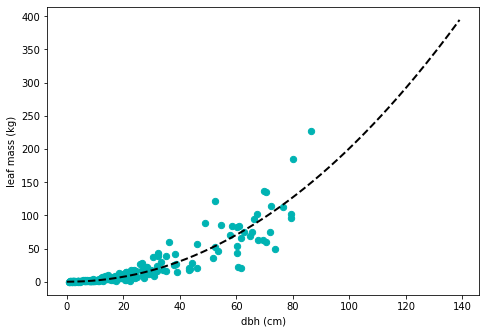

In [82]:
# dbh to crown area eq.
baad_mlfpft1 = baad_pft1.dropna(subset=['m.lf', 'DBH (cm)'])
leafmass_pars, leafmass_cov = curve_fit(f=carea_2pwr, xdata=baad_mlfpft1['DBH (cm)'], ydata=baad_mlfpft1['m.lf'])
print(leafmass_pars)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf mass (kg)')
ax.scatter(baad_mlfpft1['DBH (cm)'], baad_mlfpft1['m.lf'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), carea_2pwr(np.arange(140), *leafmass_pars), linestyle='--', linewidth=2, color='black')

[0.03222952 2.04788844]


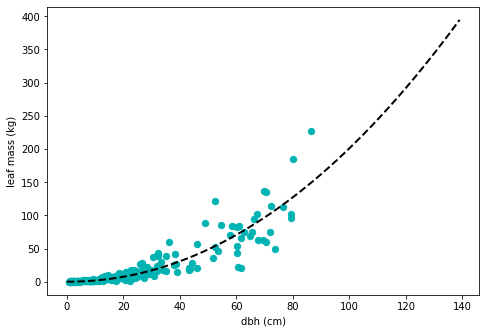

In [83]:
# dbh to leaf mass eq.
baad_mlfpft1 = baad_pft1.dropna(subset=['m.lf', 'DBH (cm)'])
leafmass_pars2, leafmass_cov2 = curve_fit(f=d2blmax_2pwr, xdata=baad_mlfpft1['DBH (cm)'], ydata=baad_mlfpft1['m.lf'])
print(leafmass_pars2)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf mass (kg)')
ax.scatter(baad_mlfpft1['DBH (cm)'], baad_mlfpft1['m.lf'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), d2blmax_2pwr(np.arange(140), *leafmass_pars2), linestyle='--', linewidth=2, color='black')

In [84]:
mlf_dfpft1 = baad_mlfpft1[['DBH (cm)','m.lf']].copy()
mlf_covpft1 = mlf_dfpft1.cov()
mlf_covpft1

,DBH (cm),m.lf
DBH (cm),469.427733,667.416792
m.lf,667.416792,1272.146755


(array([0.04751318, 0.00739726, 0.00227608, 0.00199157, 0.00227608,
        0.00142255, 0.00113804, 0.00085353, 0.00056902, 0.        ,
        0.        , 0.        , 0.00028451, 0.        , 0.00028451]),
 array([2.65800000e-03, 1.51527208e+01, 3.03027836e+01, 4.54528464e+01,
        6.06029092e+01, 7.57529720e+01, 9.09030348e+01, 1.06053098e+02,
        1.21203160e+02, 1.36353223e+02, 1.51503286e+02, 1.66653349e+02,
        1.81803412e+02, 1.96953474e+02, 2.12103537e+02, 2.27253600e+02]),
 <a list of 15 Patch objects>)

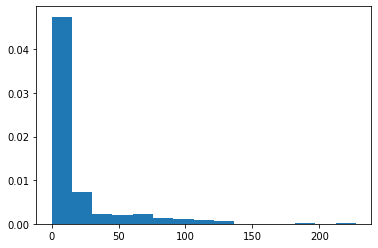

In [85]:
plt.hist(baad_pft1['m.lf'].dropna(), bins=15, density=True)

In [86]:
baad_pft1['m.lf'].describe()

count    232.000000
mean      17.884615
std       33.014379
min        0.002658
25%        0.446223
50%        3.314833
75%       17.247347
max      227.253600
Name: m.lf, dtype: float64

In [87]:
mlf_logpft1 = np.log(baad_pft1['m.lf'])
mlf_logpft1.describe()

count    232.000000
mean       0.935335
std        2.485527
min       -5.930181
25%       -0.807162
50%        1.198406
75%        2.847611
max        5.426067
Name: m.lf, dtype: float64

### From the distributions of the leaf and crown data generate samples to then calculate parameter values from

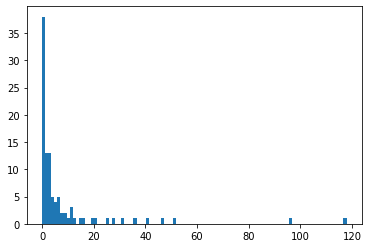

In [88]:
acp_pft1 = np.random.lognormal(mean=0.453849, sigma=2.017091, size=100)
plt.hist(acp_pft1, bins=100)
plt.show()

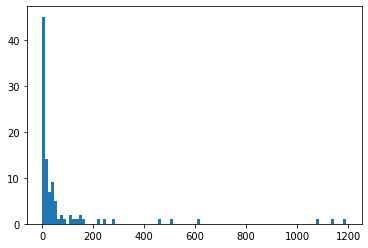

In [89]:
alf_pft1 = np.random.lognormal(mean=3.060019, sigma=2.225335, size=100)
plt.hist(alf_pft1, bins=100)
plt.show()

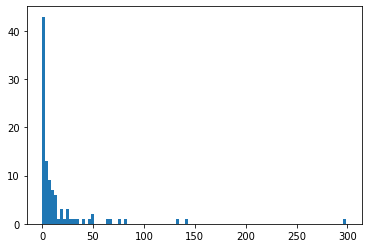

In [90]:
mlf_pft1 = np.random.lognormal(mean=1.054723, sigma=2.409439, size=100)
plt.hist(mlf_pft1, bins=100)
plt.show()

In [50]:
np.log(1)

0.0

### 3.3 Diameter to above ground biomass (d2bagw)
Here I will test the Chojnacky (2014), the Saldarriaga et al. (1998) and the FATES 2 parameter power functions.

In [51]:
# From Delucia (2000), in montane ponderosa pine at dbh=50, agb=945. We will use this as a guide.
# We need to create an objective/cost function. Use RMSE for now.

def RMSE_d2bagw(agb_mod):
    RMSE_d2bagw = np.sqrt(np.mean((agb_mod-agb_obs)**2)) 
    return RMSE_d2bagw

# For d2abagw we will calculate the 

In [63]:
# Test the functions at dbh=50 to find RMSE for observed agb at dbh 50.
dbh_bagw = 50
agb_obs=945
allom_frac=0.6
c2b=2

# Chojnacky with default parameters for pines with density < 0.45
agb_choj = d2bagw_choj(dbh_bagw,-2.6177,2.4638)

# Saldarriaga with default parameters
#agb_sal = d2bagw_sal(dbh_bagw,0.284,0.57,1.94,1)

# 2-parameter with default parameters
agb_pow = d2bagw_pow(dbh_bagw,0.1,2.4)

#print("agb_choj =", agb_choj, "agb_sal=",agb_sal,"agb_pow=",agb_pow)
print("agb_choj =", agb_choj, "agb_pow=",agb_pow)

agb_choj = 1119.6173798341167 agb_pow= 597.720312368773


In [64]:
# Calculate the RMSE for each of the functions

RMSE_choj = RMSE_d2bagw(agb_choj)

#RMSE_sal = RMSE_d2bagw(agb_sal)

RMSE_pow = RMSE_d2bagw(agb_pow)

#print("choj RMSE=",RMSE_choj,", sal RMSE=",RMSE_sal,", power RMSE=",RMSE_pow)
print("choj RMSE=",RMSE_choj,", power RMSE=",RMSE_pow)

choj RMSE= 174.61737983411672 , power RMSE= 347.27968763122703


Well, they are all terrible.  How can I make them fit better?

In [69]:
# From the FIA data, calculate per acre above ground caron by multiplying the CARBON_AG * TPA_UNADJ

# Drop rows with na for CARBON_AG == 0.000
fia_agb = fia_2pfts.dropna(subset = ['DRYBIO_BG']).copy()

fia_agb['AGB'] = (fia_agb['CARBON_AG'] * fia_agb['TPA_UNADJ'])

# Convert lbC/ac to gC/m^2 to match FATES

fia_agb['AGB'] = (fia_agb['AGB'].values * 453.592 * 0.000247105)
fia_agb['AGB'].mean()


218.40367110124382

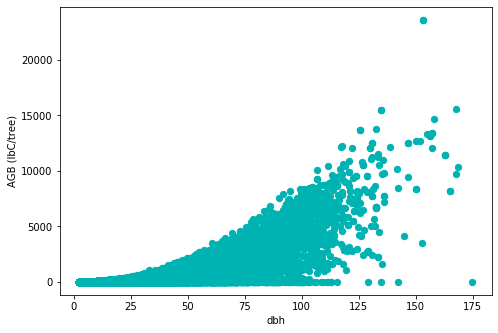

In [66]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh')
ax.set_ylabel('AGB (lbC/tree)')
ax.scatter(fia_2pfts['DBH (cm)'], fia_2pfts['CARBON_AG'], s=40, color='#00b3b3', label='Data')

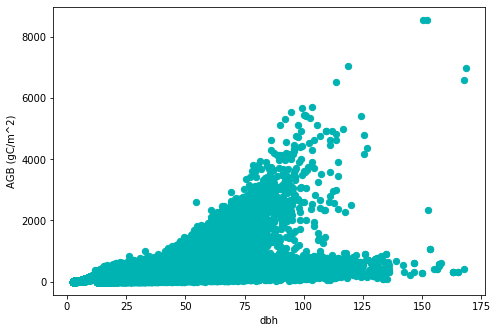

In [70]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh')
ax.set_ylabel('AGB (gC/m^2)')
#ax.scatter(fia_agb['DBH (cm)'], fia_agb['AGB'], s=40, color='#00b3b3', label='Data')
ax.scatter(fia_agb['DBH (cm)'], fia_agb['AGB'], s=40, color='#00b3b3', label='Data')


In [71]:
fia_pft1 = fia_agb.loc[(fia_2pfts['SPCD'] == 122) | (fia_agb['SPCD'] == 119) | (fia_agb['SPCD'] == 108)]
fia_pft4 = fia_agb.loc[(fia_2pfts['SPCD'] == 263) | (fia_agb['SPCD'] == 202)]

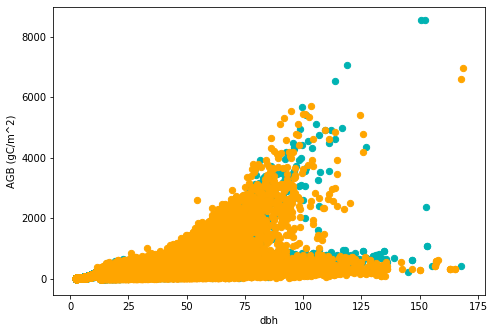

In [72]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh')
ax.set_ylabel('AGB (gC/m^2)')
ax.scatter(fia_pft1['DBH (cm)'], fia_pft1['AGB'], s=40, color='#00b3b3', label='Data')
ax.scatter(fia_pft4['DBH (cm)'], fia_pft4['AGB'], s=40, color='#ffa500', label='Data')

In [73]:
fia_agb = fia_agb.dropna(subset=['AGB', 'DBH (cm)'])
fia_agb

,PLT_CN,COUNTYCD,INVYR,CONDID,AZIMUTH,SPCD,SPGRPCD,DIA,HT,CR,...,TPA_UNADJ,DRYBIO_BG,CARBON_AG,CARBON_BG,DRYBIO_AG,SPECIES,HT (m),DBH (cm),DBH (m),AGB
0,3156095010690,9,1991,1,89.0,202,10,10.6,57.0,65.0,...,13.054000,110.124965,240.460065,55.062483,NaN,doug-fir,17.3736,26.924,0.26924,351.830502
1,3156095010690,9,1991,1,133.0,202,10,6.8,45.0,45.0,...,31.720993,37.630405,80.531243,18.815203,NaN,doug-fir,13.7160,17.272,0.17272,286.324226
3,3156095010690,9,1991,1,253.0,202,10,20.7,87.0,75.0,...,3.423000,568.025095,1261.636193,284.012548,NaN,doug-fir,26.5176,52.578,0.52578,484.047474
4,3156095010690,9,1991,1,285.0,202,10,17.3,78.0,75.0,...,4.901000,368.684807,816.035383,184.342404,NaN,doug-fir,23.7744,43.942,0.43942,448.270967
5,3156095010690,9,1991,1,47.0,202,10,1.4,12.0,25.0,...,60.000000,0.698412,1.129724,0.349206,NaN,doug-fir,3.6576,3.556,0.03556,7.597497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269937,354845607489998,81,2019,1,305.0,108,21,5.3,30.0,80.0,...,6.018046,11.534544,24.284499,5.767272,48.568998,lodge_pine,9.1440,13.462,0.13462,16.380667
269938,354845607489998,81,2019,1,356.0,108,21,5.6,20.0,75.0,...,6.018046,8.629705,18.241712,4.314853,36.483424,lodge_pine,6.0960,14.224,0.14224,12.304615
269939,354845607489998,81,2019,1,186.0,202,10,15.1,47.0,75.0,...,6.018046,163.560614,360.897561,81.780307,721.795121,doug-fir,14.3256,38.354,0.38354,243.436878
269942,354845607489998,81,2019,1,234.0,108,21,6.2,32.0,75.0,...,6.018046,19.063873,40.572438,9.531937,81.144876,lodge_pine,9.7536,15.748,0.15748,27.367399


[0.89355118 1.36203131]
[0.72792586 0.9359454  1.36203084 1.42626814]
[4.88700458 1.36206117]


/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log


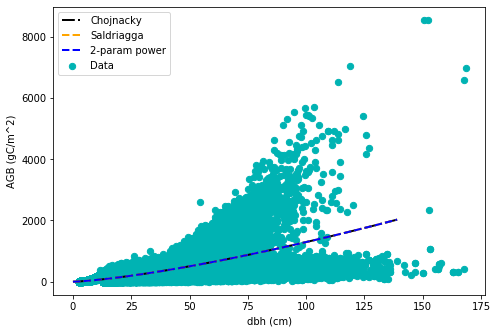

In [74]:
#fia_agb = fia_2pfts.dropna(subset=['AGB', 'DBH (cm)'])

# Define constants for the functions

# In d2bagw_sal
allom_frac = 0.6 
rho = 0.367 # Density of tree from USDA Survey of Tree Density, value for S. Idaho ponderosa pine
h_sal_mod = 29 # Observed height at dbh=50 from baad
# In d2bagw_pow
c2b = 2

pars_choj, cov_choj = curve_fit(f=d2bagw_choj, xdata=fia_agb['DBH (cm)'], ydata=fia_agb['AGB'])
print(pars_choj)
pars_sal, cov_sal = curve_fit(f=d2bagw_sal, xdata=fia_agb['DBH (cm)'], ydata=fia_agb['AGB'])
print(pars_sal)
pars_pow, cov_pow = curve_fit(f=d2bagw_pow, xdata=fia_agb['DBH (cm)'], ydata=fia_agb['AGB'])
print(pars_pow)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('AGB (gC/m^2)')
ax.scatter(fia_agb['DBH (cm)'], fia_agb['AGB'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), d2bagw_choj(np.arange(140), *pars_choj), linestyle='-.', linewidth=2, color='black', label="Chojnacky")
ax.plot(np.arange(140), d2bagw_sal(np.arange(140), *pars_sal), linestyle='--', linewidth=2, color='orange', label="Saldriagga")
ax.plot(np.arange(140), d2bagw_pow(np.arange(140), *pars_pow), linestyle='--', linewidth=2, color='blue', label="2-param power")

ax.legend()



In [75]:
## Something happened to the AGB with the conversion from lbC/tree to gC/m^2. Scewing the parameters. 
## Maybe mask for dbh>75 & agb <1000?
## I think just don't worry about the d2agb parameters.

[-1.53024522  2.15347754]
[0.09186371 0.84767401 2.15347752 1.48279119]
[0.43296559 2.1534773 ]


/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log


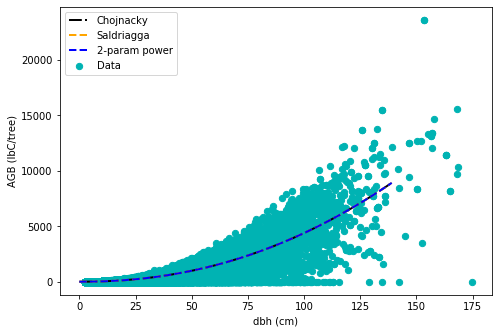

In [76]:
fia_cag = fia_2pfts.dropna(subset=['CARBON_AG', 'DBH (cm)'])

# Define constants for the functions

# In d2bagw_sal
allom_frac = 0.6 
rho = 0.367 # Density of tree from USDA Survey of Tree Density, value for S. Idaho ponderosa pine
h_sal_mod = 29 # Observed height at dbh=50 from baad
# In d2bagw_pow
c2b = 2

pars_choj, cov_choj = curve_fit(f=d2bagw_choj, xdata=fia_cag['DBH (cm)'], ydata=fia_cag['CARBON_AG'])
print(pars_choj)
pars_sal, cov_sal = curve_fit(f=d2bagw_sal, xdata=fia_cag['DBH (cm)'], ydata=fia_cag['CARBON_AG'])
print(pars_sal)
pars_pow, cov_pow = curve_fit(f=d2bagw_pow, xdata=fia_cag['DBH (cm)'], ydata=fia_cag['CARBON_AG'])
print(pars_pow)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('AGB (lbC/tree)')
ax.scatter(fia_cag['DBH (cm)'], fia_cag['CARBON_AG'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), d2bagw_choj(np.arange(140), *pars_choj), linestyle='-.', linewidth=2, color='black', label="Chojnacky")
ax.plot(np.arange(140), d2bagw_sal(np.arange(140), *pars_sal), linestyle='--', linewidth=2, color='orange', label="Saldriagga")
ax.plot(np.arange(140), d2bagw_pow(np.arange(140), *pars_pow), linestyle='--', linewidth=2, color='blue', label="2-param power")

ax.legend()



### For the d2ca, d2blmax, and d2agb chose a mean and variance and ramdonly sample 100 times. These will be brought over to the SCGSR Trait Matrix

In [91]:
# Dbh to project crown area, 2pwr
d2ca_p1 = crownarea_pars[0]
d2ca_p2 = crownarea_pars[1]
# Dbh to leaf area, 2pwr
d2la_p1 = leafarea_pars[0]
d2la_p2 = leafarea_pars[1]

# d2lf_ediff = crown area p2 - leaf area p2
crown_exp_diff = crownarea_pars[1] - leafarea_pars[1]

# d2leaf mass, carea 2pwr
d2blmax_ca_p1 = leafmass_pars[0]
d2blmax_ca_p2 = leafmass_pars[1]

# Dbh to leaf biomass d2blmax, 2pwr
d2blmax_p1 = leafmass_pars2[0]
d2blmax_p2 = leafmass_pars2[1] # crown_to_dbh_exp(crownare_exp)


In [92]:
print(d2blmax_p1, d2blmax_p2)

0.03222951712453022 2.047888443390719


In [93]:
# could create a range of p1 and p2, then a for loop to recalculate crown area or leaf 
# random
random.seed(10)

d2ca_p1_rand = np.random.normal(loc=d2ca_p1, scale=(d2ca_p1/10), size=100)
d2ca_p2_rand = np.random.normal(loc=d2ca_p2, scale=(d2ca_p2/10), size=100)


In [94]:
d2ca_params = pd.DataFrame({'d2ca_p1': d2ca_p1_rand, 'd2ca_p2': d2ca_p2_rand}, columns = ['d2ca_p1', 'd2ca_p2'])
d2ca_params.head()

,d2ca_p1,d2ca_p2
0,0.056673,1.540737
1,0.053239,1.662423
2,0.059573,1.454868
3,0.051418,1.411788
4,0.052744,1.524001


In [95]:
# random
random.seed(10)

d2la_p1_rand = np.random.normal(loc=d2la_p1, scale=(d2la_p1/10), size=100)
d2la_p2_rand = np.random.normal(loc=d2la_p2, scale=(d2la_p2/10), size=100)

In [96]:
d2la_params = pd.DataFrame({'d2la_p1': d2la_p1_rand, 'd2la_p2': d2la_p2_rand}, columns = ['d2la_p1', 'd2la_p2'])
d2la_params.head()

,d2la_p1,d2la_p2
0,0.376806,1.755008
1,0.399298,1.518022
2,0.337016,1.540059
3,0.447754,1.702068
4,0.373575,1.813654


In [97]:
# random
random.seed(10)

d2blmax_ca_p1_rand = np.random.normal(loc=d2blmax_ca_p1, scale=(d2blmax_ca_p1/10), size=100)
d2blmax_ca_p2_rand = np.random.normal(loc=d2blmax_ca_p2, scale=(d2blmax_ca_p2/10), size=100)

In [98]:
d2blmax_ca_params = pd.DataFrame({'d2blmax_ca_p1': d2blmax_ca_p1_rand, 'd2blmax_ca_p2': d2blmax_ca_p2_rand}, 
                                 columns = ['d2blmax_ca_p1', 'd2blmax_ca_p2'])
d2blmax_ca_params.head()

,d2blmax_ca_p1,d2blmax_ca_p2
0,0.019266,2.201814
1,0.015427,2.255808
2,0.019364,2.024992
3,0.015417,1.682843
4,0.015000,2.308635


In [99]:
# random
random.seed(10)

d2blmax_p1_rand = np.random.normal(loc=d2blmax_p1, scale=(d2blmax_p1/10), size=100)
d2blmax_p2_rand = np.random.normal(loc=d2blmax_p2, scale=(d2blmax_p2/10), size=100)

In [100]:
d2blmax_params = pd.DataFrame({'d2blmax_p1': d2blmax_p1_rand, 'd2blmax_p2': d2blmax_p2_rand}, 
                                 columns = ['d2blmax_p1', 'd2blmax_p2'])
d2blmax_params.head()

,d2blmax_p1,d2blmax_p2
0,0.031118,1.993442
1,0.026805,2.221785
2,0.036146,1.868516
3,0.029892,2.035320
4,0.034909,1.877431


### Calculate crown area from the random parameters

In [101]:
# Calc crown area from random params

ca_rand_p = []

for i in range(100):

    test_ca = carea_2pwr(np.arange(0,90,5), d2ca_p1_rand[i], d2ca_p2_rand[i])
    ca_rand_p.append(test_ca)

ca_opt = carea_2pwr(np.arange(0,90,5), d2ca_p1, d2ca_p2)

In [102]:
print(d2ca_p1_rand[1], d2ca_p2_rand[1], ca_rand_p[1])

0.05323924869131265 1.6624233397775254 [ 0.          0.77306492  2.44711995  4.80168291  7.74630421 11.22535324
 15.1996213  19.63933025 24.52075508 29.82434995 35.53360799 41.63431971
 48.11406587 54.96185666 62.1678666  69.72323447 77.61990917 85.85052838]


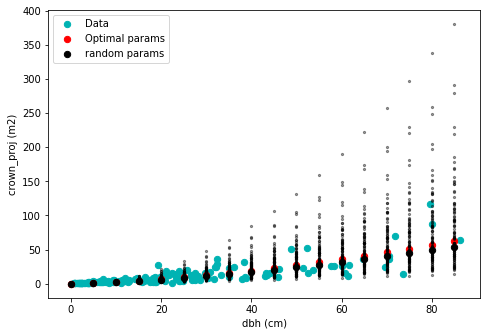

In [103]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('crown_proj (m2)')
ax.scatter(baad_acppft1['DBH (cm)'], baad_acppft1['a.cp'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), ca_opt, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), ca_rand_p[7], s=40, color='black', label='random params')
for i in range(100):
    ax.scatter(np.arange(0,90,5), ca_rand_p[i], s=5, color='black', alpha=0.4)
#ax.set_ylim(0,150)
plt.legend()

(array([ 5., 12., 15., 17., 16., 14., 11.,  4.,  2.,  4.]),
 array([0.04465147, 0.0469755 , 0.04929953, 0.05162356, 0.05394759,
        0.05627162, 0.05859566, 0.06091969, 0.06324372, 0.06556775,
        0.06789178]),
 <a list of 10 Patch objects>)

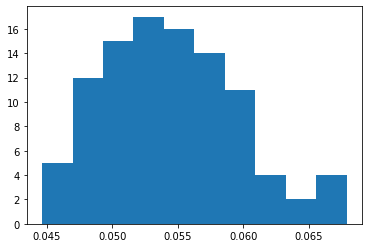

In [104]:
plt.hist(d2ca_p1_rand)

(array([ 2.,  9., 14., 19., 19., 15., 10.,  8.,  3.,  1.]),
 array([1.2737115 , 1.34704801, 1.42038453, 1.49372104, 1.56705755,
        1.64039406, 1.71373057, 1.78706709, 1.8604036 , 1.93374011,
        2.00707662]),
 <a list of 10 Patch objects>)

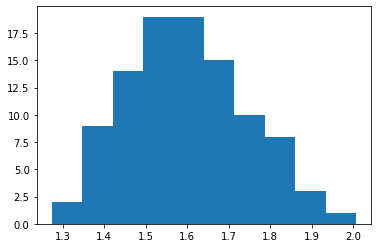

In [105]:
plt.hist(d2ca_p2_rand)

In [106]:
# d2ca_p2 > 1.77 caused problems
d2ca_params.index[d2ca_params['d2ca_p2'] >= 1.77].to_list()

[9, 10, 11, 21, 24, 26, 37, 47, 64, 68, 75, 79, 82, 88, 98]

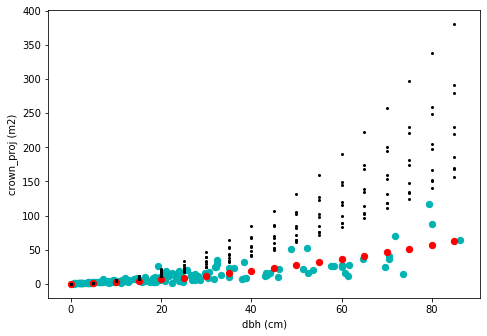

In [130]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('crown_proj (m2)')
ax.scatter(baad_acppft1['DBH (cm)'], baad_acppft1['a.cp'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), ca_opt, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), ca_rand_p[9], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_p[10], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_p[11], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_p[21], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_p[24], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_p[26], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_p[37], s=4, color='black', label='random params')
#ax.scatter(np.arange(0,90,5), ca_rand_p[47], s=4, color='black', label='random params')
#ax.scatter(np.arange(0,90,5), ca_rand_p[64], s=4, color='black', label='random params')
#ax.scatter(np.arange(0,90,5), ca_rand_p[75], s=4, color='black', label='random params')
#ax.scatter(np.arange(0,90,5), ca_rand_p[79], s=4, color='black', label='random params')
#ax.scatter(np.arange(0,90,5), ca_rand_p[82], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_p[88], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_p[98], s=4, color='black', label='random params')

In [132]:
# drop the problem values from the dataframe and save to a csv

d2ca_params_cleanpft1 = d2ca_params.drop([d2ca_params.index[9], d2ca_params.index[10],d2ca_params.index[11], 
                                      d2ca_params.index[21], d2ca_params.index[24], d2ca_params.index[26],
                                        d2ca_params.index[37], d2ca_params.index[88], d2ca_params.index[98]])

In [134]:
len(d2ca_params_cleanpft1)

91

In [136]:
# read out to a csv for use in the traits matrix
#d2ca_params_cleanpft1.to_csv('/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/SCGSR_PARAMS/d2ca_params_clean_pft1_20210727.csv', index=False)


### Calculate leaf area from the random parameters

In [137]:
la_rand_p = []

for i in range(100):

    test_la = carea_2pwr(np.arange(0,90,5), d2la_p1_rand[i], d2la_p2_rand[i])
    la_rand_p.append(test_la)

la_opt = carea_2pwr(np.arange(0,90,5), d2la_p1, d2la_p2)

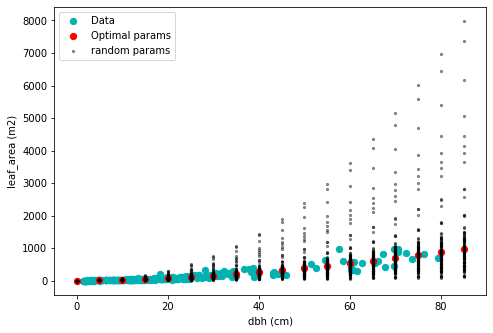

In [138]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf_area (m2)')
ax.scatter(baad_alfpft1['DBH (cm)'], baad_alfpft1['a.lf'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), la_opt, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), la_rand_p[7], s=5, color='black', alpha=0.4, label='random params')
for i in range(100):
    ax.scatter(np.arange(0,90,5), la_rand_p[i], s=5, color='black', alpha=0.4)
#ax.set_ylim(0,150)
plt.legend()

(array([ 1.,  5.,  8., 15., 13., 13., 22., 10.,  9.,  4.]),
 array([0.27530063, 0.29461669, 0.31393274, 0.3332488 , 0.35256485,
        0.37188091, 0.39119697, 0.41051302, 0.42982908, 0.44914513,
        0.46846119]),
 <a list of 10 Patch objects>)

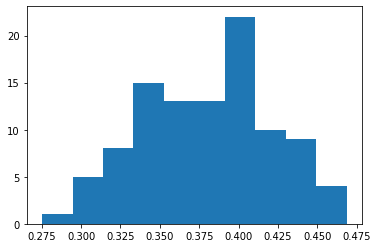

In [139]:
plt.hist(d2la_p1_rand)

(array([ 5.,  1.,  9., 16., 24., 27.,  7.,  5.,  4.,  2.]),
 array([1.28264138, 1.3813014 , 1.47996143, 1.57862145, 1.67728148,
        1.7759415 , 1.87460153, 1.97326155, 2.07192158, 2.1705816 ,
        2.26924163]),
 <a list of 10 Patch objects>)

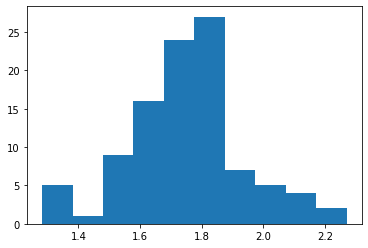

In [140]:
plt.hist(d2la_p2_rand)

In [141]:
# d2la_p2 > 1.95 caused problems
d2la_params.index[d2la_params['d2la_p2'] > 1.95].to_list()

[16, 23, 33, 34, 36, 37, 64, 65, 71, 86, 89, 98]

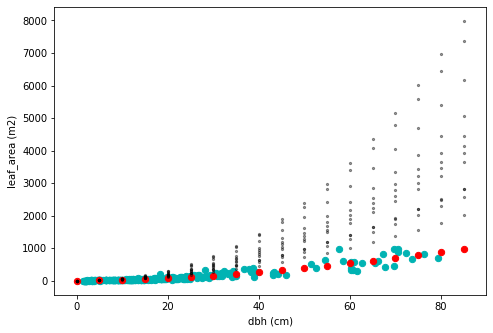

In [145]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf_area (m2)')
ax.scatter(baad_alfpft1['DBH (cm)'], baad_alfpft1['a.lf'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), la_opt, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), la_rand_p[16], s=5, color='black', alpha=0.4, label='random params')
ax.scatter(np.arange(0,90,5), la_rand_p[23], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_p[33], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_p[34], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_p[36], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_p[37], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_p[64], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_p[65], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_p[71], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_p[86], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_p[89], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_p[98], s=5, color='black', alpha=0.4)


In [146]:
d2la_params_cleanpft1 = d2la_params.drop([d2la_params.index[16], d2la_params.index[23],d2la_params.index[33], 
                                      d2la_params.index[34], d2la_params.index[36], d2la_params.index[37],
                                           d2la_params.index[64], d2la_params.index[65], d2la_params.index[71],
                                        d2la_params.index[86], d2la_params.index[89], d2la_params.index[98]])


len(d2la_params_cleanpft1)

88

In [147]:
# read out to a csv for use in the traits matrix
#d2la_params_cleanpft1.to_csv('/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/SCGSR_PARAMS/d2la_params_clean__pft1_20210727.csv', index=False)


### Calculate leaf mass from the random parameters

In [148]:
bl_rand_p = []

for i in range(100):

    test_bl = d2blmax_2pwr(np.arange(0,90,5), d2blmax_p1_rand[i], d2blmax_p2_rand[i])
    bl_rand_p.append(test_bl)

bl_opt = d2blmax_2pwr(np.arange(0,90,5), d2blmax_p1, d2blmax_p2)

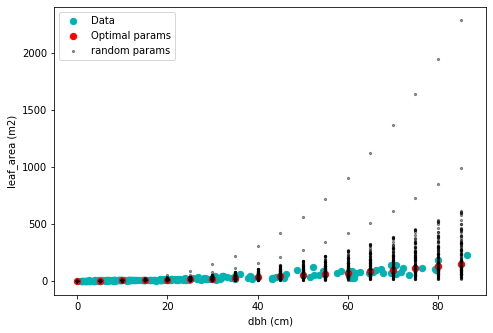

In [149]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf_area (m2)')
ax.scatter(baad_mlfpft1['DBH (cm)'], baad_mlfpft1['m.lf'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), bl_opt, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), bl_rand_p[7], s=5, color='black', alpha=0.4, label='random params')
for i in range(100):
    ax.scatter(np.arange(0,90,5), bl_rand_p[i], s=5, color='black', alpha=0.4)
#ax.set_ylim(0,150)
plt.legend()

(array([ 5.,  7.,  7., 17., 20., 21.,  7.,  9.,  4.,  3.]),
 array([0.02493084, 0.02647803, 0.02802522, 0.02957241, 0.0311196 ,
        0.03266679, 0.03421398, 0.03576117, 0.03730836, 0.03885554,
        0.04040273]),
 <a list of 10 Patch objects>)

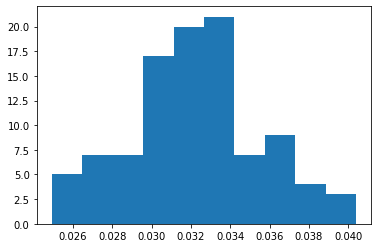

In [150]:
plt.hist(d2blmax_p1_rand)

(array([ 4.,  5., 10., 17., 19., 22., 16.,  5.,  1.,  1.]),
 array([1.59701109, 1.70416368, 1.81131627, 1.91846886, 2.02562144,
        2.13277403, 2.23992662, 2.34707921, 2.4542318 , 2.56138439,
        2.66853698]),
 <a list of 10 Patch objects>)

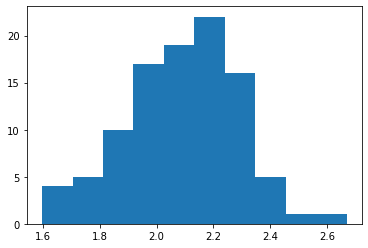

In [151]:
plt.hist(d2blmax_p2_rand)

In [155]:
# d2blmax_p2 > 2.2 caused problems
d2blmax_params.index[d2blmax_params['d2blmax_p2'] > 2.3].to_list()

[6, 8, 23, 34, 51, 55, 68, 74, 81, 84, 86]

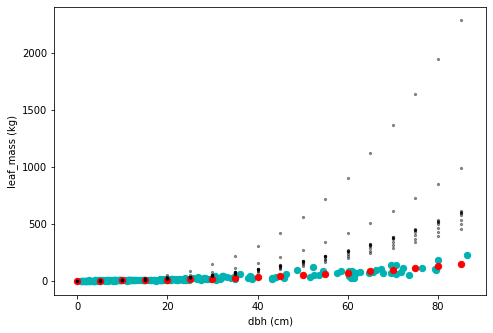

In [162]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf_mass (kg)')
ax.scatter(baad_mlfpft1['DBH (cm)'], baad_mlfpft1['m.lf'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), bl_opt, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), bl_rand_p[51], s=5, color='black', alpha=0.4, label='random params')
ax.scatter(np.arange(0,90,5), bl_rand_p[55], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_p[68], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_p[6], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_p[8], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_p[23], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_p[74], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_p[81], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_p[84], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_p[86], s=5, color='black', alpha=0.4)

In [163]:
d2blmax_params_cleanpft1 = d2blmax_params.drop([d2blmax_params.index[6], d2blmax_params.index[8],d2blmax_params.index[23], 
                                      d2blmax_params.index[51], d2blmax_params.index[55], d2blmax_params.index[68],
                                           d2blmax_params.index[74], d2blmax_params.index[81], d2blmax_params.index[84],
                                               d2blmax_params.index[86]])


len(d2blmax_params_cleanpft1)


90

In [164]:
# read out to a csv for use in the traits matrix
#d2blmax_params_cleanpft1.to_csv('/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/SCGSR_PARAMS/d2blmax_params_clean__pft1_20210727.csv', index=False)


#### Repeat for pft2

1. Get optimal param values for PFT2
2. From distribution of PFT2 traits create synthetic data
3. Get optimal parameters from synthetic data
4. Refit
5. Clean up data that would create crazy values

[0.05482925 1.58372154]


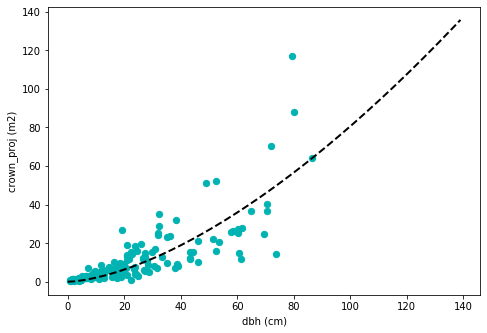

In [165]:
# Crown area

baad_acppft2 = baad_pft1.dropna(subset=['a.cp', 'DBH (cm)'])
crownarea_pars2, crownarea_cov2 = curve_fit(f=carea_2pwr, xdata=baad_acppft2['DBH (cm)'], ydata=baad_acppft2['a.cp'])
print(crownarea_pars)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('crown_proj (m2)')
ax.scatter(baad_acppft2['DBH (cm)'], baad_acppft2['a.cp'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), carea_2pwr(np.arange(140), *crownarea_pars2), linestyle='--', linewidth=2, color='black')

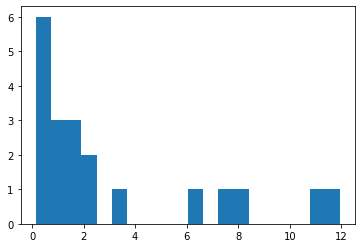

In [168]:
plt.hist(baad_pft2['a.cp'].dropna(), bins=20)
plt.show()

In [169]:
baad_pft2['a.cp'].describe()

count    20.000000
mean      3.154972
std       3.735028
min       0.143013
25%       0.487230
50%       1.579346
75%       4.183134
max      11.954729
Name: a.cp, dtype: float64

In [170]:
acp_logpft2 = np.log(baad_pft2['a.cp'])
acp_logpft2.describe()

count    20.000000
mean      0.404784
std       1.336735
min      -1.944819
25%      -0.733657
50%       0.454930
75%       1.394526
max       2.481127
Name: a.cp, dtype: float64

[1.46587146 1.31858912]


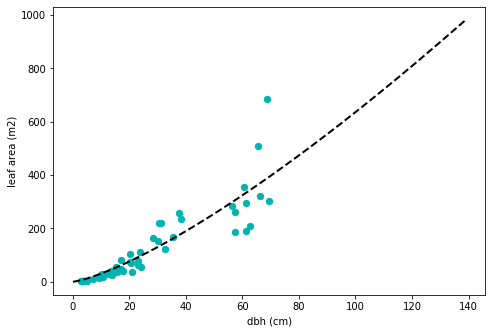

In [179]:
# leaf area

baad_alfpft2 = baad_pft2.dropna(subset=['a.lf', 'DBH (cm)'])
leafarea_pars2, leafarea_cov2 = curve_fit(f=carea_2pwr, xdata=baad_alfpft2['DBH (cm)'], ydata=baad_alfpft2['a.lf'])
print(leafarea_pars2)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf area (m2)')
ax.scatter(baad_alfpft2['DBH (cm)'], baad_alfpft2['a.lf'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), carea_2pwr(np.arange(140), *leafarea_pars2), linestyle='--', linewidth=2, color='black')
#ax.set_xlim(0,100)

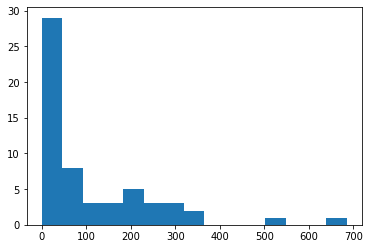

In [174]:
plt.hist(baad_pft2['a.lf'].dropna(), bins=15)
plt.show()

In [175]:
baad_pft2['a.lf'].describe()

count     58.000000
mean     108.752087
std      138.674074
min        0.964377
25%        6.694040
50%       45.475000
75%      182.082500
max      684.418349
Name: a.lf, dtype: float64

In [176]:
alf_logpft2 = np.log(baad_pft2['a.lf'])
alf_logpft2.describe()

count    58.000000
mean      3.514120
std       1.914397
min      -0.036273
25%       1.862701
50%       3.813815
75%       5.203555
max       6.528569
Name: a.lf, dtype: float64

In [180]:
# Calculate the leaf crown exponent difference
leaf_crown_exponent_diffpft2 = crownarea_pars2[1] - leafarea_pars2[1]
print(leaf_crown_exponent_diffpft2)

0.2651324194687448


[0.01611414 2.04789757]


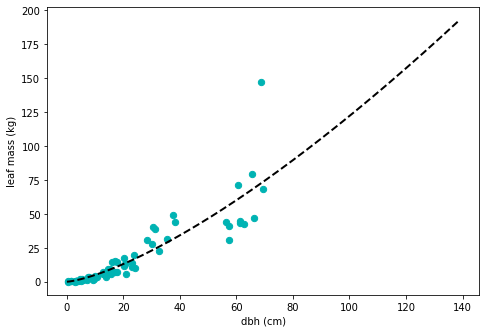

In [181]:
# Leaf mass

baad_mlfpft2 = baad_pft2.dropna(subset=['m.lf', 'DBH (cm)'])
leafmass_parspft2, leafmass_covpft2 = curve_fit(f=carea_2pwr, xdata=baad_mlfpft2['DBH (cm)'], ydata=baad_mlfpft2['m.lf'])
print(leafmass_pars)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf mass (kg)')
ax.scatter(baad_mlfpft2['DBH (cm)'], baad_mlfpft2['m.lf'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), carea_2pwr(np.arange(140), *leafmass_parspft2), linestyle='--', linewidth=2, color='black')

[0.40918732 1.38810629]


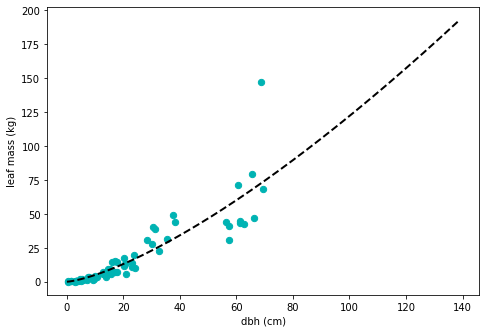

In [182]:
baad_mlfpft2 = baad_pft2.dropna(subset=['m.lf', 'DBH (cm)'])
leafmass_parspft22, leafmass_covpft22 = curve_fit(f=d2blmax_2pwr, xdata=baad_mlfpft2['DBH (cm)'], ydata=baad_mlfpft2['m.lf'])
print(leafmass_parspft22)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf mass (kg)')
ax.scatter(baad_mlfpft2['DBH (cm)'], baad_mlfpft2['m.lf'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), d2blmax_2pwr(np.arange(140), *leafmass_parspft22), linestyle='--', linewidth=2, color='black')

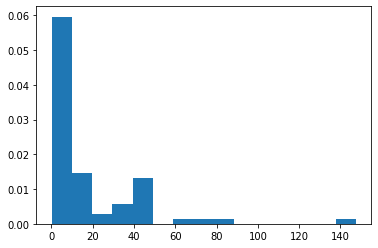

In [183]:
plt.hist(baad_pft2['m.lf'].dropna(), bins=15, density=True)
plt.show()

In [184]:
baad_pft2['m.lf'].describe()

count     70.000000
mean      17.051539
std       25.044361
min        0.038012
25%        1.122670
50%        6.410000
75%       26.655000
max      147.504669
Name: m.lf, dtype: float64

In [185]:
mlf_logpft2 = np.log(baad_pft2['m.lf'])
mlf_logpft2.describe()

count    70.000000
mean      1.450409
std       2.106153
min      -3.269862
25%       0.114617
50%       1.856005
75%       3.279414
max       4.993860
Name: m.lf, dtype: float64

### From the distributions of the leaf and crown data, generate samples to then calculate parameter values from

In [190]:
acppft2 = np.random.lognormal(mean=0.404784, sigma=1.336735, size=100)
#plt.hist(acppft2, bins=100)
#plt.show()

In [191]:
alfpft2 = np.random.lognormal(mean=3.514120, sigma=1.914397, size=100)
#plt.hist(alfpft2, bins=100)
#plt.show()

In [192]:
mlfpft2 = np.random.lognormal(mean=1.4505409, sigma=2.106153, size=100)
#plt.hist(mlfpft2, bins=100)
#plt.show()

In [193]:
# Oh yeah, I forget that isn't useful because I need the corresponding dbhs to go with the calculated leaf and canopy values

### For the d2ca, d2blmax, and d2agb chose a mean and variance and ramdonly sample 100 times. These will be brought over to the SCGSR Trait Matrix

In [197]:
# Remember for PFT2. Should probably take the time to name things better before going on GitHub

# Dbh to project crown area, 2pwr
d2ca_p1pft2 = crownarea_pars2[0]
d2ca_p2pft2 = crownarea_pars2[1]
# Dbh to leaf area, 2pwr
d2la_p1pft2 = leafarea_pars2[0]
d2la_p2pft2 = leafarea_pars2[1]

# d2lf_ediff = crown area p2 - leaf area p2
crown_exp_diffpft2 = crownarea_pars2[1] - leafarea_pars2[1]

# d2leaf mass, carea 2pwr
d2blmax_ca_p1pft2 = leafmass_parspft2[0]
d2blmax_ca_p2pft2 = leafmass_parspft2[1]

# Dbh to leaf biomass d2blmax, 2pwr
d2blmax_p1pft2 = leafmass_parspft22[0]
d2blmax_p2pft2 = leafmass_parspft22[1] # crown_to_dbh_exp(crownare_exp)

In [205]:
random.seed(10)

d2ca_p1_randpft2 = np.random.normal(loc=d2ca_p1pft2, scale=(d2ca_p1pft2/10), size=100)
d2ca_p2_randpft2 = np.random.normal(loc=d2ca_p2pft2, scale=(d2ca_p2pft2/10), size=100)

d2ca_params_pft2 = pd.DataFrame({'d2ca_p1': d2ca_p1_randpft2, 'd2ca_p2': d2ca_p2_randpft2}, columns = ['d2ca_p1', 'd2ca_p2'])
d2ca_params_pft2.head()

,d2ca_p1,d2ca_p2
0,0.053649,1.751646
1,0.060249,1.635891
2,0.052591,1.673473
3,0.047781,1.587130
4,0.054814,1.629912


In [206]:
# random
random.seed(10)

d2la_p1_randpft2 = np.random.normal(loc=d2la_p1pft2, scale=(d2la_p1pft2/10), size=100)
d2la_p2_randpft2 = np.random.normal(loc=d2la_p2pft2, scale=(d2la_p2pft2/10), size=100)

d2la_params_pft2 = pd.DataFrame({'d2la_p1': d2la_p1_randpft2, 'd2la_p2': d2la_p2_randpft2}, columns = ['d2la_p1', 'd2la_p2'])
d2la_params_pft2.head()

,d2la_p1,d2la_p2
0,1.281993,1.226923
1,1.289546,1.137846
2,1.571489,1.231047
3,1.165579,1.435732
4,1.675719,1.305538


In [207]:
# random
random.seed(10)

d2blmax_ca_p1_randpft2 = np.random.normal(loc=d2blmax_ca_p1pft2, scale=(d2blmax_ca_p1pft2/10), size=100)
d2blmax_ca_p2_randpft2 = np.random.normal(loc=d2blmax_ca_p2pft2, scale=(d2blmax_ca_p2pft2/10), size=100)

d2blmax_ca_params_pft2 = pd.DataFrame({'d2blmax_ca_p1': d2blmax_ca_p1_randpft2, 'd2blmax_ca_p2': d2blmax_ca_p2_randpft2}, 
                                 columns = ['d2blmax_ca_p1', 'd2blmax_ca_p2'])
d2blmax_ca_params_pft2.head()

,d2blmax_ca_p1,d2blmax_ca_p2
0,0.243222,1.455888
1,0.207859,1.436146
2,0.191682,1.251829
3,0.266087,1.516008
4,0.237213,1.032837


In [208]:
random.seed(10)

d2blmax_p1_randpft2 = np.random.normal(loc=d2blmax_p1pft2, scale=(d2blmax_p1pft2/10), size=100)
d2blmax_p2_randpft2 = np.random.normal(loc=d2blmax_p2pft2, scale=(d2blmax_p2pft2/10), size=100)

d2blmax_params_pft2 = pd.DataFrame({'d2blmax_p1': d2blmax_p1_randpft2, 'd2blmax_p2': d2blmax_p2_randpft2}, 
                                 columns = ['d2blmax_p1', 'd2blmax_p2'])
d2blmax_params_pft2.head()

,d2blmax_p1,d2blmax_p2
0,0.410493,1.178946
1,0.415942,1.280493
2,0.440080,1.493738
3,0.360786,1.318213
4,0.449777,1.546099


### Calculate crown area from the random parameters

In [209]:
# Calc crown area from random params

ca_rand_pft2 = []

for i in range(100):

    test_ca = carea_2pwr(np.arange(0,90,5), d2ca_p1_randpft2[i], d2ca_p2_randpft2[i])
    ca_rand_pft2.append(test_ca)

ca_optpft2 = carea_2pwr(np.arange(0,90,5), d2ca_p1pft2, d2ca_p2pft2)

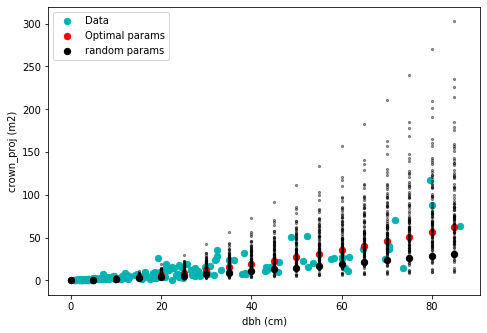

In [210]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('crown_proj (m2)')
ax.scatter(baad_acppft2['DBH (cm)'], baad_acppft2['a.cp'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), ca_optpft2, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), ca_rand_pft2[7], s=40, color='black', label='random params')
for i in range(100):
    ax.scatter(np.arange(0,90,5), ca_rand_pft2[i], s=5, color='black', alpha=0.4)
#ax.set_ylim(0,150)
plt.legend()

(array([ 2.,  4., 11., 19., 21., 17., 13.,  8.,  2.,  3.]),
 array([0.04250452, 0.04522547, 0.04794642, 0.05066737, 0.05338832,
        0.05610928, 0.05883023, 0.06155118, 0.06427213, 0.06699308,
        0.06971404]),
 <a list of 10 Patch objects>)

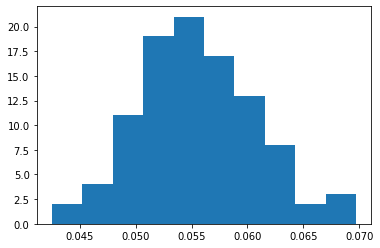

In [211]:
plt.hist(d2ca_p1_randpft2)

(array([ 4.,  0.,  3., 12., 13., 17., 22., 16.,  8.,  5.]),
 array([1.16655574, 1.24021173, 1.31386771, 1.3875237 , 1.46117968,
        1.53483567, 1.60849166, 1.68214764, 1.75580363, 1.82945961,
        1.9031156 ]),
 <a list of 10 Patch objects>)

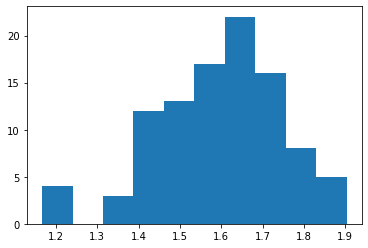

In [212]:
plt.hist(d2ca_p2_randpft2)

In [213]:
# d2ca_p2 > 1.77 caused problems
d2ca_params_pft2.index[d2ca_params_pft2['d2ca_p2'] >= 1.77].to_list()

[13, 27, 30, 32, 69, 71, 73, 82, 90, 98, 99]

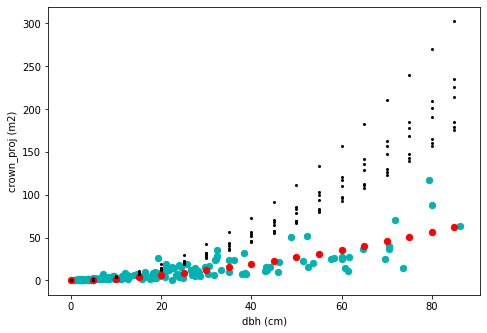

In [229]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('crown_proj (m2)')
ax.scatter(baad_acppft2['DBH (cm)'], baad_acppft2['a.cp'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), ca_optpft2, s=40, color='red', label='Optimal params')
#ax.scatter(np.arange(0,90,5), ca_rand_pft2[13], s=4, color='black', label='random params')
#ax.scatter(np.arange(0,90,5), ca_rand_pft2[27], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_pft2[30], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_pft2[32], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_pft2[69], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_pft2[71], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_pft2[73], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_pft2[82], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_pft2[90], s=4, color='black', label='random params')
#ax.scatter(np.arange(0,90,5), ca_rand_pft2[98], s=4, color='black', label='random params')
#ax.scatter(np.arange(0,90,5), ca_rand_pft2[99], s=4, color='black', label='random params')

In [230]:
# drop the problem values from the dataframe and save to a csv

d2ca_params_clean_pft2 = d2ca_params_pft2.drop([d2ca_params_pft2.index[30], d2ca_params_pft2.index[32],
                                                d2ca_params_pft2.index[69], d2ca_params_pft2.index[71], 
                                                d2ca_params_pft2.index[73], d2ca_params_pft2.index[82],
                                               d2ca_params_pft2.index[90]])



In [231]:
len(d2ca_params_clean_pft2)

93

In [232]:
# read out to a csv for use in the traits matrix
#d2ca_params_clean_pft2.to_csv('/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/SCGSR_PARAMS/d2ca_params_clean_pft2_20210727.csv', index=False)

In [233]:
la_rand_pft2 = []

for i in range(100):

    test_la = carea_2pwr(np.arange(0,90,5), d2la_p1_randpft2[i], d2la_p2_randpft2[i])
    la_rand_pft2.append(test_la)

la_optpft2 = carea_2pwr(np.arange(0,90,5), d2la_p1pft2, d2la_p2pft2)

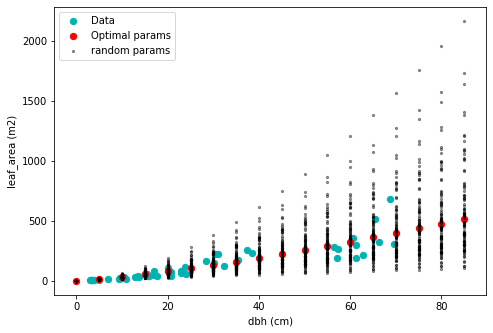

In [234]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf_area (m2)')
ax.scatter(baad_alfpft2['DBH (cm)'], baad_alfpft2['a.lf'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), la_optpft2, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), la_rand_pft2[7], s=5, color='black', alpha=0.4, label='random params')
for i in range(100):
    ax.scatter(np.arange(0,90,5), la_rand_pft2[i], s=5, color='black', alpha=0.4)
#ax.set_ylim(0,150)
plt.legend()

(array([ 4.,  7.,  8., 12., 18., 15., 15., 10.,  8.,  3.]),
 array([1.09099608, 1.16125433, 1.23151258, 1.30177084, 1.37202909,
        1.44228734, 1.51254559, 1.58280384, 1.6530621 , 1.72332035,
        1.7935786 ]),
 <a list of 10 Patch objects>)

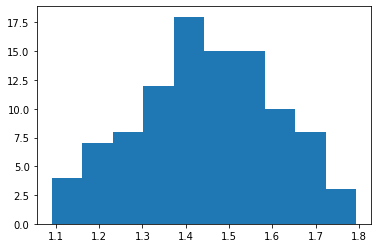

In [235]:
plt.hist(d2la_p1_randpft2)

(array([ 2.,  1.,  8., 19., 21., 24., 11.,  7.,  6.,  1.]),
 array([0.95153682, 1.02391039, 1.09628396, 1.16865752, 1.24103109,
        1.31340466, 1.38577823, 1.45815179, 1.53052536, 1.60289893,
        1.6752725 ]),
 <a list of 10 Patch objects>)

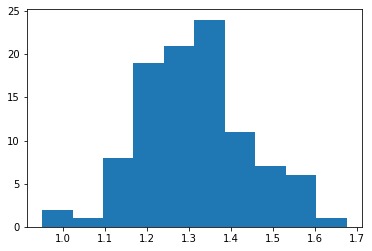

In [236]:
plt.hist(d2la_p2_randpft2)

In [239]:
# d2la_p2 > 1.95 caused problems
d2la_params_pft2.index[d2la_params_pft2['d2la_p2'] > 1.5].to_list()

[28, 59, 60, 66, 67, 88, 97]

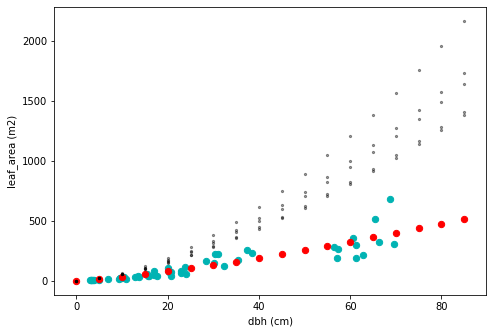

In [244]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf_area (m2)')
ax.scatter(baad_alfpft2['DBH (cm)'], baad_alfpft2['a.lf'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), la_optpft2, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), la_rand_pft2[66], s=5, color='black', alpha=0.4, label='random params')
ax.scatter(np.arange(0,90,5), la_rand_pft2[67], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_pft2[97], s=5, color='black', alpha=0.4)
#ax.scatter(np.arange(0,90,5), la_rand_pft2[28], s=5, color='black', alpha=0.4)
#ax.scatter(np.arange(0,90,5), la_rand_pft2[59], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_pft2[60], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_pft2[88], s=5, color='black', alpha=0.4)

In [248]:
d2la_params_clean_pft2 = d2la_params_pft2.drop([d2la_params_pft2.index[60], d2la_params_pft2.index[66],
                                                d2la_params_pft2.index[67], d2la_params_pft2.index[88], 
                                                d2la_params_pft2.index[97]])


len(d2la_params_clean_pft2)

95

In [249]:
# read out to a csv for use in the traits matrix
#d2la_params_clean_pft2.to_csv('/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/SCGSR_PARAMS/d2la_params_clean_pft2_20210727.csv', index=False)


In [250]:
bl_rand_pft2 = []

for i in range(100):

    test_bl = d2blmax_2pwr(np.arange(0,90,5), d2blmax_p1_randpft2[i], d2blmax_p2_randpft2[i])
    bl_rand_pft2.append(test_bl)

bl_optpft2 = d2blmax_2pwr(np.arange(0,90,5), d2blmax_p1pft2, d2blmax_p2pft2)

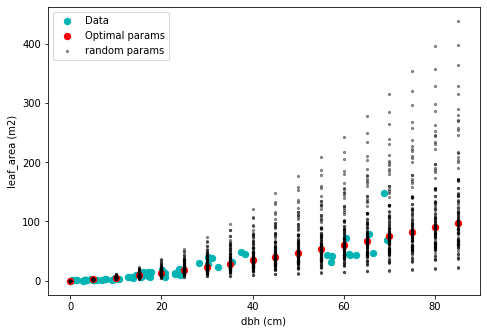

In [251]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf_area (m2)')
ax.scatter(baad_mlfpft2['DBH (cm)'], baad_mlfpft2['m.lf'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), bl_optpft2, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), bl_rand_pft2[7], s=5, color='black', alpha=0.4, label='random params')
for i in range(100):
    ax.scatter(np.arange(0,90,5), bl_rand_pft2[i], s=5, color='black', alpha=0.4)
#ax.set_ylim(0,150)
plt.legend()

(array([ 3.,  4., 14., 12., 21., 26., 10.,  6.,  1.,  3.]),
 array([0.30770437, 0.32958033, 0.35145629, 0.37333226, 0.39520822,
        0.41708418, 0.43896015, 0.46083611, 0.48271207, 0.50458804,
        0.526464  ]),
 <a list of 10 Patch objects>)

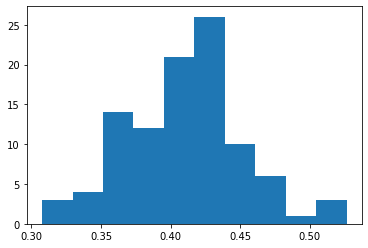

In [252]:
plt.hist(d2blmax_p1_randpft2)

(array([ 2.,  3.,  3., 17., 22., 23., 11.,  7.,  8.,  4.]),
 array([1.04877824, 1.11721172, 1.1856452 , 1.25407868, 1.32251216,
        1.39094564, 1.45937912, 1.5278126 , 1.59624607, 1.66467955,
        1.73311303]),
 <a list of 10 Patch objects>)

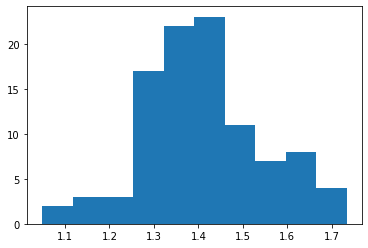

In [253]:
plt.hist(d2blmax_p2_randpft2)

In [257]:
# d2blmax_p2 > 2.2 caused problems
d2blmax_params_pft2.index[d2blmax_params_pft2['d2blmax_p2'] > 1.60].to_list()

[5, 6, 17, 23, 51, 59, 62, 72, 77, 82, 86, 90]

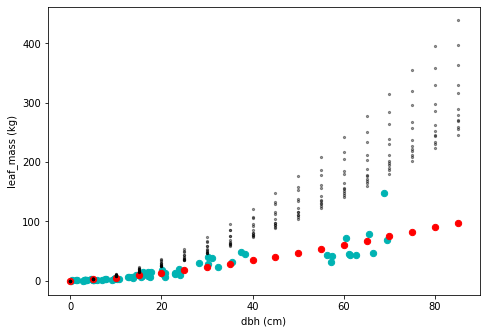

In [264]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf_mass (kg)')
ax.scatter(baad_mlfpft2['DBH (cm)'], baad_mlfpft2['m.lf'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), bl_optpft2, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), bl_rand_pft2[17], s=5, color='black', alpha=0.4, label='random params')
ax.scatter(np.arange(0,90,5), bl_rand_pft2[59], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_pft2[82], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_pft2[86], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_pft2[90], s=5, color='black', alpha=0.4)

ax.scatter(np.arange(0,90,5), bl_rand_pft2[5], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_pft2[6], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_pft2[23], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_pft2[51], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_pft2[62], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_pft2[72], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_pft2[77], s=5, color='black', alpha=0.4)


In [265]:
d2blmax_params_clean_pft2 = d2blmax_params_pft2.drop([d2blmax_params_pft2.index[17], d2blmax_params_pft2.index[59],
                                                    d2blmax_params_pft2.index[82], d2blmax_params_pft2.index[86],
                                                     d2blmax_params_pft2.index[90], d2blmax_params_pft2.index[5],
                                                     d2blmax_params_pft2.index[6], d2blmax_params_pft2.index[23],
                                                     d2blmax_params_pft2.index[51], d2blmax_params_pft2.index[62],
                                                     d2blmax_params_pft2.index[72], d2blmax_params_pft2.index[77]])


len(d2blmax_params_clean_pft2)


88

In [266]:
# read out to a csv for use in the traits matrix
#d2blmax_params_clean_pft2.to_csv('/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/SCGSR_PARAMS/d2blmax_params_clean_pft2_20210727.csv', index=False)